In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
!pip install faker
from faker import Faker
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Initialisation
fake = Faker()
np.random.seed(42)
random.seed(42)

# Paramètres
START_DATE = "2018-01-01"  # 2 ans avant l'original
END_DATE = "2024-12-31"    # Jusqu'à fin 2024
PRODUCTS = [f"P{str(i).zfill(4)}" for i in range(1, 101)]  # 100 produits (double)
CATEGORIES = ['Groceries', 'Toys', 'Electronics', 'Clothing', 'Furniture', 'Home Appliances', 'Sports', 'Beauty']  # +3 catégories
REGIONS = ['North', 'South', 'East', 'West', 'Central', 'International']  # +2 régions
WEATHER_CONDITIONS = ['Sunny', 'Cloudy', 'Rainy', 'Snowy', 'Windy', 'Foggy']  # +2 conditions
SEASONS = ['Spring', 'Summer', 'Autumn', 'Winter']

# Paramètres de volume
ENTRIES_PER_DAY_MIN = 300  # Volume minimum par jour
ENTRIES_PER_DAY_MAX = 800  # Volume maximum par jour
HIGH_VOLUME_DAYS = ['Friday', 'Saturday', 'Sunday']  # Weekends = plus de données
SPECIAL_EVENTS_MULTIPLIER = 3  # Multiplicateur pour jours spéciaux

# Fonction pour déterminer la saison
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# Fonction pour générer les jours spéciaux (promotions, fêtes)
def get_special_days(year):
    special_days = []

    # Jours fixes
    special_days.append(datetime(year, 1, 1))    # Nouvel An
    special_days.append(datetime(year, 12, 25))  # Noël
    special_days.append(datetime(year, 12, 26))  # Boxing Day
    special_days.append(datetime(year, 12, 31))  # Réveillon
    special_days.append(datetime(year, 7, 1))    # Canada Day
    special_days.append(datetime(year, 7, 4))    # Indépendance US

    # Black Friday (4ème vendredi de novembre)
    november_first = datetime(year, 11, 1)
    first_friday = november_first + timedelta(days=(4 - november_first.weekday()) % 7)
    black_friday = first_friday + timedelta(weeks=3)
    special_days.append(black_friday)
    special_days.append(black_friday + timedelta(days=1))  # Saturday
    special_days.append(black_friday + timedelta(days=2))  # Sunday

    # Cyber Monday (lundi après Black Friday)
    cyber_monday = black_friday + timedelta(days=3)
    special_days.append(cyber_monday)

    # Prime Day (mi-juillet)
    prime_day = datetime(year, 7, 15)
    special_days.append(prime_day)

    # Singles Day (11/11)
    singles_day = datetime(year, 11, 11)
    special_days.append(singles_day)

    # Back to School (août)
    back_to_school = datetime(year, 8, 20)
    special_days.append(back_to_school)

    # Seasonal sales
    special_days.append(datetime(year, 4, 1))   # Spring sale
    special_days.append(datetime(year, 9, 1))   # Fall sale

    return set(special_days)

# Fonction pour déterminer le type de jour
def get_day_type(date, special_days):
    if date in special_days:
        return 'special'
    elif date.weekday() >= 5:  # Weekend
        return 'weekend'
    else:
        return 'weekday'

# Statistiques par catégorie (avec variations temporelles)
def get_category_stats(category, year):
    base_stats = {
        'Groceries': {'price_mean': 45, 'price_std': 20, 'units_mean': 180, 'units_std': 120},
        'Toys': {'price_mean': 55, 'price_std': 25, 'units_mean': 150, 'units_std': 110},
        'Electronics': {'price_mean': 350, 'price_std': 200, 'units_mean': 80, 'units_std': 60},
        'Clothing': {'price_mean': 65, 'price_std': 35, 'units_mean': 200, 'units_std': 150},
        'Furniture': {'price_mean': 280, 'price_std': 150, 'units_mean': 60, 'units_std': 45},
        'Home Appliances': {'price_mean': 220, 'price_std': 120, 'units_mean': 70, 'units_std': 50},
        'Sports': {'price_mean': 120, 'price_std': 80, 'units_mean': 90, 'units_std': 70},
        'Beauty': {'price_mean': 40, 'price_std': 25, 'units_mean': 170, 'units_std': 130}
    }

    stats = base_stats[category].copy()

    # Inflation annuelle (2-4% par an)
    inflation_rate = 1 + ((year - 2018) * 0.025)
    stats['price_mean'] *= inflation_rate
    stats['price_std'] *= inflation_rate

    # Croissance annuelle des ventes (3-8% par an)
    growth_rate = 1 + ((year - 2018) * 0.05)
    stats['units_mean'] *= growth_rate
    stats['units_std'] *= growth_rate

    return stats

# Fonction pour générer les données d'un jour
def generate_day_data(date, special_days):
    day_type = get_day_type(date, special_days)

    # Déterminer le volume du jour
    if day_type == 'special':
        daily_entries = np.random.randint(ENTRIES_PER_DAY_MIN * 2, ENTRIES_PER_DAY_MAX * SPECIAL_EVENTS_MULTIPLIER)
    elif day_type == 'weekend':
        daily_entries = np.random.randint(ENTRIES_PER_DAY_MIN * 2, ENTRIES_PER_DAY_MAX * 2)
    else:
        daily_entries = np.random.randint(ENTRIES_PER_DAY_MIN, ENTRIES_PER_DAY_MAX)

    data = []
    season = get_season(date)
    year = date.year

    # Mapping produit -> catégorie (cohérent)
    # Créer un mapping stable pour ce jour
    product_category_map = {}
    for product in PRODUCTS[:daily_entries]:
        if product not in product_category_map:
            product_category_map[product] = random.choice(CATEGORIES)

    for product in PRODUCTS[:daily_entries]:
        category = product_category_map[product]
        region = random.choice(REGIONS)

        # Obtenir les statistiques pour cette année
        stats = get_category_stats(category, year)

        # Générer le prix
        price = np.random.normal(stats['price_mean'], stats['price_std'])
        price = max(1, min(1000, round(price, 2)))

        # Générer les unités vendues
        if day_type == 'special':
            units_multiplier = np.random.uniform(1.5, 3.0)
        elif day_type == 'weekend':
            units_multiplier = np.random.uniform(1.2, 1.8)
        else:
            units_multiplier = np.random.uniform(0.8, 1.2)

        units = np.random.normal(stats['units_mean'], stats['units_std'])
        units = int(max(0, units * units_multiplier))

        # Discount basé sur le type de jour
        if day_type == 'special':
            discount = random.choice([0, 10, 15, 20, 25, 30, 40, 50])
        elif day_type == 'weekend':
            discount = random.choice([0, 5, 10, 15, 20])
        else:
            discount = random.choice([0, 0, 5, 10])

        # Prix compétiteur
        competitor_variation = np.random.uniform(-0.2, 0.15)
        competitor_pricing = max(0.5, round(price * (1 + competitor_variation), 2))

        # Condition météo basée sur la saison et région
        weather_weights = {
            'North': {
                'Winter': [0.10, 0.20, 0.20, 0.40, 0.05, 0.05], # Sunny, Cloudy, Rainy, Snowy, Windy, Foggy
                'Spring': [0.30, 0.40, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Autumn': [0.20, 0.30, 0.30, 0.10, 0.05, 0.05]
            },
            'South': {
                'Winter': [0.30, 0.30, 0.20, 0.10, 0.05, 0.05],
                'Spring': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.50, 0.20, 0.20, 0.00, 0.05, 0.05],
                'Autumn': [0.30, 0.30, 0.20, 0.10, 0.05, 0.05]
            },
            'East': {
                'Winter': [0.20, 0.30, 0.20, 0.20, 0.05, 0.05],
                'Spring': [0.35, 0.35, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Autumn': [0.25, 0.30, 0.25, 0.15, 0.05, 0.05]
            },
            'West': {
                'Winter': [0.30, 0.30, 0.10, 0.20, 0.05, 0.05],
                'Spring': [0.40, 0.30, 0.15, 0.00, 0.10, 0.05],
                'Summer': [0.50, 0.20, 0.10, 0.00, 0.10, 0.10],
                'Autumn': [0.35, 0.30, 0.20, 0.05, 0.05, 0.05]
            },
            'Central': {
                'Winter': [0.20, 0.40, 0.10, 0.20, 0.05, 0.05],
                'Spring': [0.30, 0.40, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.40, 0.30, 0.10, 0.00, 0.10, 0.10],
                'Autumn': [0.20, 0.30, 0.30, 0.10, 0.05, 0.05]
            },
            'International': { # More generic, less extreme weather
                'Winter': [0.40, 0.20, 0.20, 0.00, 0.10, 0.10],
                'Spring': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.50, 0.20, 0.10, 0.00, 0.10, 0.10],
                'Autumn': [0.30, 0.30, 0.20, 0.10, 0.05, 0.05]
            }
        }

        region_key = region if region in weather_weights else 'Central'
        probabilities = weather_weights[region_key][season]
        # Normalize probabilities to ensure they sum to 1.0 due to potential float inaccuracies
        sum_probs = sum(probabilities)
        if sum_probs == 0:
            # If probabilities sum to 0, distribute evenly (handle edge case, though unlikely)
            normalized_probabilities = [1.0 / len(probabilities)] * len(probabilities)
        else:
            normalized_probabilities = [p / sum_probs for p in probabilities]

        weather = np.random.choice(WEATHER_CONDITIONS, p=normalized_probabilities)

        # Holiday/Promotion
        holiday_promotion = 1 if (day_type == 'special' or random.random() < 0.3) else 0

        data.append([
            date.strftime("%Y-%m-%d"),
            product,
            category,
            region,
            units,
            price,
            discount,
            weather,
            holiday_promotion,
            competitor_pricing,
            season
        ])

    return data

# Fonction principale pour générer les données
def generate_inventory_data_parallel(start_date_str, end_date_str, num_workers=8):
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    # Générer tous les jours spéciaux
    all_special_days = set()
    for year in range(start_date.year, end_date.year + 1):
        all_special_days.update(get_special_days(year))

    # Créer la liste de toutes les dates
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += timedelta(days=1)

    # Diviser le travail entre les workers
    chunk_size = len(date_list) // num_workers
    date_chunks = [date_list[i:i + chunk_size] for i in range(0, len(date_list), chunk_size)]

    all_data = []

    # Utiliser le multiprocessing pour accélérer
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for chunk in date_chunks:
            futures.append(executor.submit(process_date_chunk, chunk, all_special_days))

        for future in as_completed(futures):
            try:
                chunk_data = future.result()
                all_data.extend(chunk_data)
            except Exception as e:
                print(f"Erreur dans un worker: {e}")

    # Aplatir la liste
    flat_data = [item for sublist in all_data for item in sublist]

    # Créer le DataFrame
    df = pd.DataFrame(flat_data, columns=[
        'Date', 'Product ID', 'Category', 'Region', 'Units Sold',
        'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
        'Competitor Pricing', 'Seasonality'
    ])

    return df

def process_date_chunk(date_chunk, special_days):
    chunk_data = []
    for date in date_chunk:
        day_data = generate_day_data(date, special_days)
        chunk_data.append(day_data)
    return chunk_data

# Génération et sauvegarde
if __name__ == "__main__":
    print(f"Génération des données du {START_DATE} au {END_DATE}...")
    print(f"Produits: {len(PRODUCTS)}")
    print(f"Catégories: {len(CATEGORIES)}")
    print(f"Régions: {len(REGIONS)}")
    print(f"Volume estimé: ~{ENTRIES_PER_DAY_MAX * 2557} entrées (max)")

    # Utiliser tous les cores disponibles
    num_workers = mp.cpu_count()
    print(f"Utilisation de {num_workers} workers en parallèle...")

    inventory_df = generate_inventory_data_parallel(START_DATE, END_DATE, num_workers)

    # Vérification
    print(f"\nGénération terminée!")
    print(f"Nombre total d'entrées : {len(inventory_df):,}")
    print(f"Période : {inventory_df['Date'].min()} to {inventory_df['Date'].max()}")
    print(f"Taille mémoire: {inventory_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Aperçu
    print("\nAperçu des données :")
    print(inventory_df.head(10))

    # Statistiques sommaires
    print("\n" + "="*50)
    print("STATISTIQUES PAR CATÉGORIE")
    print("="*50)

    for category in CATEGORIES:
        cat_data = inventory_df[inventory_df['Category'] == category]
        if len(cat_data) > 0:
            print(f"\n{category.upper()}:")
            print(f"  Entrées: {len(cat_data):,} ({len(cat_data)/len(inventory_df)*100:.1f}%)")
            print(f"  Prix moyen: ${cat_data['Price'].mean():.2f}")
            print(f"  Prix médian: ${cat_data['Price'].median():.2f}")
            print(f"  Unités moyennes vendues: {cat_data['Units Sold'].mean():.1f}")
            print(f"  Discount moyen: {cat_data['Discount'].mean():.1f}%")

    print("\n" + "="*50)
    print("STATISTIQUES PAR ANNÉE")
    print("="*50)

    inventory_df['Year'] = pd.to_datetime(inventory_df['Date']).dt.year
    for year in sorted(inventory_df['Year'].unique()):
        year_data = inventory_df[inventory_df['Year'] == year]
        print(f"\n{year}:")
        print(f"  Entrées: {len(year_data):,}")
        print(f"  Revenu total estimé: ${(year_data['Units Sold'] * year_data['Price']).sum():,.0f}")
        print(f"  Ventes totales: {year_data['Units Sold'].sum():,.0f}")

    # Sauvegarde avec compression pour réduire la taille
    output_files = [
        "retail_store_inventory_massive.csv",
        "retail_store_inventory_massive.csv.gz",
        "retail_store_inventory_massive.parquet"
    ]

    for output_file in output_files:
        print(f"\nSauvegarde dans : {output_file}")

        if output_file.endswith('.csv'):
            inventory_df.to_csv(output_file, index=False)
        elif output_file.endswith('.csv.gz'):
            inventory_df.to_csv(output_file, index=False, compression='gzip')
        elif output_file.endswith('.parquet'):
            inventory_df.to_parquet(output_file, index=False)

        print(f"  ✓ Fichier créé")

    # Sauvegarder un échantillon pour tests
    # Check if inventory_df has enough rows before sampling 10,000
    if len(inventory_df) >= 10000:
        sample_size = 10000
    else:
        # If not enough rows, sample all available rows
        sample_size = len(inventory_df)

    if sample_size > 0: # Only try to sample if there is data
        sample_df = inventory_df.sample(n=sample_size, random_state=42)
        sample_df.to_csv("retail_store_inventory_sample.csv", index=False)
        print(f"\nÉchantillon de {sample_size:,} lignes sauvegardé dans: retail_store_inventory_sample.csv")
    else:
        print(f"\nImpossible de sauvegarder un échantillon car le DataFrame est vide.")

    print(f"\n{'='*60}")
    print(f"DONNÉES GÉNÉRÉES AVEC SUCCÈS!")
    print(f"Volume total: {len(inventory_df):,} entrées")
    print(f"Période: {START_DATE} - {END_DATE}")
    print(f"Taille estimée: ~{(len(inventory_df) * 100) / (1024**2):.1f} MB en CSV")
    print(f"{'='*60}")

Génération des données du 2018-01-01 au 2024-12-31...
Produits: 100
Catégories: 8
Régions: 6
Volume estimé: ~2045600 entrées (max)
Utilisation de 2 workers en parallèle...

Génération terminée!
Nombre total d'entrées : 255,700
Période : 2018-01-01 to 2024-12-31
Taille mémoire: 97.33 MB

Aperçu des données :
         Date Product ID         Category         Region  Units Sold   Price  \
0  2018-01-01      P0001           Sports          North         336   75.98   
1  2018-01-01      P0002      Electronics  International          48  331.08   
2  2018-01-01      P0003        Furniture  International         153  291.97   
3  2018-01-01      P0004  Home Appliances           West         221  395.49   
4  2018-01-01      P0005        Furniture  International         161  200.23   
5  2018-01-01      P0006      Electronics          South         503   54.73   
6  2018-01-01      P0007  Home Appliances          North         251  156.99   
7  2018-01-01      P0008      Electronics          

In [7]:
newly_created_df = pd.read_csv("retail_store_inventory_massive.csv")
print("Dataset successfully loaded. Here's a preview:")
print(newly_created_df.head())
print(f"Total entries: {len(newly_created_df):,}")

Dataset successfully loaded. Here's a preview:
         Date Product ID         Category         Region  Units Sold   Price  \
0  2018-01-01      P0001           Sports          North         336   75.98   
1  2018-01-01      P0002      Electronics  International          48  331.08   
2  2018-01-01      P0003        Furniture  International         153  291.97   
3  2018-01-01      P0004  Home Appliances           West         221  395.49   
4  2018-01-01      P0005        Furniture  International         161  200.23   

   Discount Weather Condition  Holiday/Promotion  Competitor Pricing  \
0        10             Rainy                  1               76.66   
1        20             Rainy                  1              281.42   
2        25             Foggy                  1              233.66   
3        25            Cloudy                  1              319.58   
4        15             Sunny                  1              176.50   

  Seasonality  Year  
0      Winter  20

## Load and Preprocess Data


In [9]:
df = newly_created_df.copy()

# 2. Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# 3. Aggregate the DataFrame by 'Date', summing the 'Units Sold' for each day
daily_sales_df = df.groupby('Date')['Units Sold'].sum().reset_index()

# 5. Rename the 'Units Sold' column to 'Total Units Sold'
daily_sales_df.rename(columns={'Units Sold': 'Total Units Sold'}, inplace=True)

# 6. Display the first 5 rows and the data types of daily_sales_df
print("First 5 rows of daily_sales_df:")
print(daily_sales_df.head())
print("\nData types of daily_sales_df:")
print(daily_sales_df.info())

First 5 rows of daily_sales_df:
        Date  Total Units Sold
0 2018-01-01             29720
1 2018-01-02             12482
2 2018-01-03             13163
3 2018-01-04             13584
4 2018-01-05             13897

Data types of daily_sales_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              2557 non-null   datetime64[ns]
 1   Total Units Sold  2557 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 40.1 KB
None


## Feature Engineering


In [10]:
df = newly_created_df.copy()

# 1. Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Re-create daily_sales_df with additional aggregated columns
daily_sales_df = df.groupby('Date').agg(
    total_units_sold=('Units Sold', 'sum'),
    weather_condition=('Weather Condition', 'first'),
    seasonality=('Seasonality', 'first'),
    holiday_promotion=('Holiday/Promotion', 'max') # max for a flag to indicate if any promotion happened
).reset_index()

# Rename the total_units_sold column to 'Total Units Sold' for consistency
daily_sales_df.rename(columns={'total_units_sold': 'Total Units Sold'}, inplace=True)

# 2. Extract time-based features
daily_sales_df['year'] = daily_sales_df['Date'].dt.year
daily_sales_df['month'] = daily_sales_df['Date'].dt.month
daily_sales_df['dayofweek'] = daily_sales_df['Date'].dt.dayofweek
daily_sales_df['dayofyear'] = daily_sales_df['Date'].dt.dayofyear
daily_sales_df['weekofyear'] = daily_sales_df['Date'].dt.isocalendar().week.astype(int)

# 3. Generate a lag feature
daily_sales_df['Total Units Sold_lag_7'] = daily_sales_df['Total Units Sold'].shift(7)

# 4. Generate rolling window features
daily_sales_df['Total Units Sold_roll_3_mean'] = daily_sales_df['Total Units Sold'].rolling(window=3).mean()
daily_sales_df['Total Units Sold_roll_7_mean'] = daily_sales_df['Total Units Sold'].rolling(window=7).mean()

# 5. Remove rows with NaN values introduced by lag and rolling window calculations
daily_sales_df.dropna(inplace=True)

# 6. Apply one-hot encoding to 'Weather Condition' and 'Seasonality' columns
daily_sales_df = pd.get_dummies(daily_sales_df, columns=['weather_condition', 'seasonality'], drop_first=True, dtype=int)

# 7. Display the first 5 rows and the data types of the updated daily_sales_df
print("First 5 rows of daily_sales_df with new features:")
print(daily_sales_df.head())
print("\nData types of daily_sales_df with new features:")
print(daily_sales_df.info())

First 5 rows of daily_sales_df with new features:
         Date  Total Units Sold  holiday_promotion  year  month  dayofweek  \
7  2018-01-08             14015                  1  2018      1          0   
8  2018-01-09             12579                  1  2018      1          1   
9  2018-01-10             13684                  1  2018      1          2   
10 2018-01-11             11559                  1  2018      1          3   
11 2018-01-12             12113                  1  2018      1          4   

    dayofyear  weekofyear  Total Units Sold_lag_7  \
7           8           2                 29720.0   
8           9           2                 12482.0   
9          10           2                 13163.0   
10         11           2                 13584.0   
11         12           2                 13897.0   

    Total Units Sold_roll_3_mean  Total Units Sold_roll_7_mean  \
7                   17724.666667                  15185.714286   
8                   15720.6666

## Prepare Data for XGBoost


In [11]:
import numpy as np

# 1. Create the target variable by shifting the 'Total Units Sold' column by 7 days
daily_sales_df['Target_Units_Sold'] = daily_sales_df['Total Units Sold'].shift(-7)

# 2. Remove any rows that contain NaN values, which might be introduced by the target shift
daily_sales_df.dropna(inplace=True)

# 3. Define the features (X) by dropping the 'Date', 'Total Units Sold', and 'Target_Units_Sold' columns
X = daily_sales_df.drop(columns=['Date', 'Total Units Sold', 'Target_Units_Sold'])

# 4. Define the target (y) as the 'Target_Units_Sold' column
y = daily_sales_df['Target_Units_Sold']

# 5. Determine a split point for the time-series data (e.g., 80% for training, 20% for testing)
split_index = int(len(daily_sales_df) * 0.8)
split_date = daily_sales_df.iloc[split_index]['Date']

print(f"Total data points: {len(daily_sales_df)}")
print(f"Split point index for training data: {split_index}")
print(f"Split date for training and testing: {split_date.strftime('%Y-%m-%d')}")

# 6. Split the features (X) and target (y) into training and testing sets
X_train = X[daily_sales_df['Date'] < split_date]
X_test = X[daily_sales_df['Date'] >= split_date]
y_train = y[daily_sales_df['Date'] < split_date]
y_test = y[daily_sales_df['Date'] >= split_date]

# Display the shapes of the resulting datasets
print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nFirst 5 rows of X_train:")
print(X_train.head())
print("\nFirst 5 rows of y_train:")
print(y_train.head())

Total data points: 2543
Split point index for training data: 2034
Split date for training and testing: 2023-08-04

Shape of X_train: (2034, 17)
Shape of X_test: (509, 17)
Shape of y_train: (2034,)
Shape of y_test: (509,)

First 5 rows of X_train:
    holiday_promotion  year  month  dayofweek  dayofyear  weekofyear  \
7                   1  2018      1          0          8           2   
8                   1  2018      1          1          9           2   
9                   1  2018      1          2         10           2   
10                  1  2018      1          3         11           2   
11                  1  2018      1          4         12           2   

    Total Units Sold_lag_7  Total Units Sold_roll_3_mean  \
7                  29720.0                  17724.666667   
8                  12482.0                  15720.666667   
9                  13163.0                  13426.000000   
10                 13584.0                  12607.333333   
11                 1

## Train XGBoost Model

### Subtask:
Initialize and train an XGBoost Regressor model using the prepared training data (features and target).


**Reasoning**:
The subtask requires importing XGBRegressor, initializing it with specific parameters, and then training the model using the prepared X_train and y_train datasets.



In [12]:
import xgboost as xgb

# 1. Initialize an XGBRegressor model
# Using n_estimators=100, learning_rate=0.1, random_state=42 as a starting point
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# 2. Train the model using the .fit() method with X_train and y_train
print("Training XGBoost model...")
model.fit(X_train, y_train)
print("XGBoost model training complete.")

Training XGBoost model...
XGBoost model training complete.


## Make Predictions

### Subtask:
Use the trained XGBoost model to make demand predictions for the designated test set (the future week).


**Reasoning**:
The subtask requires using the trained XGBoost model to make predictions on the `X_test` dataset and storing the results in `y_pred`.



In [13]:
y_pred = model.predict(X_test)
print("Predictions made for the test set.")
print(f"First 5 predictions: {y_pred[:5]}")

Predictions made for the test set.
First 5 predictions: [16817.893 26016.271 26295.707 16385.984 16246.371]


## Evaluate Model Performance

### Subtask:
Assess the performance of the XGBoost model using appropriate regression metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) on the test set.


**Reasoning**:
To assess the model's performance, I will calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) using `y_test` and `y_pred`, and then print these metrics.



In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# 2. Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# 3. Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# 4. Print the calculated MAE and RMSE values
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 2289.41
Root Mean Squared Error (RMSE): 4142.80


## Visualize Predictions

### Subtask:
Create a plot to visualize the actual vs. predicted 'Units Sold' for a representative product or over a specific period.


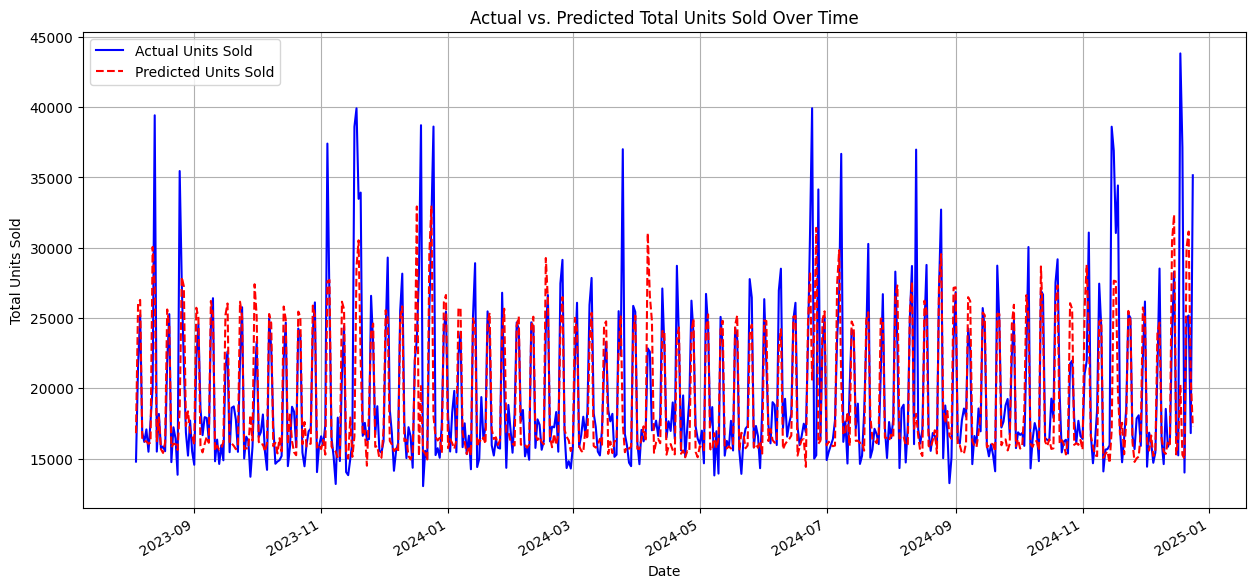

Visualization of Actual vs. Predicted Total Units Sold complete.


In [15]:
import matplotlib.pyplot as plt

# 1. Create a DataFrame for visualization
# Get the dates corresponding to the test set
# Use the index of X_test to filter daily_sales_df to get the correct 'Date' values
test_dates = daily_sales_df.loc[X_test.index]['Date']

results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Units Sold': y_test,
    'Predicted Units Sold': y_pred
})

# Sort by Date to ensure proper plotting
results_df.sort_values(by='Date', inplace=True)

# 2. Plotting
plt.figure(figsize=(15, 7))
plt.plot(results_df['Date'], results_df['Actual Units Sold'], label='Actual Units Sold', color='blue')
plt.plot(results_df['Date'], results_df['Predicted Units Sold'], label='Predicted Units Sold', color='red', linestyle='--')

# 3. Label the x-axis as 'Date' and the y-axis as 'Total Units Sold'
plt.xlabel('Date')
plt.ylabel('Total Units Sold')

# 4. Add a title to the plot
plt.title('Actual vs. Predicted Total Units Sold Over Time')

# 5. Include a legend
plt.legend()

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate()

# Display the plot
plt.grid(True)
plt.show()

print("Visualization of Actual vs. Predicted Total Units Sold complete.")

## Hyperparameter Tuning for XGBoost

In [16]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 1. Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# 2. Initialize an XGBRegressor object
xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist') # Use 'hist' for faster training

# 3. Instantiate GridSearchCV
# Using neg_mean_absolute_error as a scoring metric (GridSearchCV minimizes, so we use negative)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3, # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1, # Use all available processors
    verbose=2
)

# 4. Fit GridSearchCV to the training data
print("Starting GridSearchCV for hyperparameter tuning...")
grid_search.fit(X_train, y_train)
print("GridSearchCV complete.")

# 5. Print the best parameters and best score
print("\nBest parameters found:", grid_search.best_params_)
# Convert the negative MAE score back to positive for better interpretation
print("Best MAE score (negated, so lower is better):", -grid_search.best_score_)

Starting GridSearchCV for hyperparameter tuning...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
GridSearchCV complete.

Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best MAE score (negated, so lower is better): 2443.984915134126


**Reasoning**:
Now that the best hyperparameters have been identified through GridSearchCV, the next step is to initialize a new XGBoost Regressor model with these optimal parameters and train it using the training data (`X_train` and `y_train`). Subsequently, this optimized model will be used to make predictions on the test set (`X_test`).



In [17]:
import xgboost as xgb

# 1. Retrieve the best parameters from GridSearchCV
best_params = grid_search.best_params_

# 2. Initialize a new XGBRegressor model with the best parameters
optimized_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    random_state=42, # Ensure reproducibility
    tree_method='hist' # Use 'hist' for faster training
)

# 3. Train the optimized model using the training data
print("Training optimized XGBoost model with best parameters...")
optimized_model.fit(X_train, y_train)
print("Optimized XGBoost model training complete.")

# 4. Make predictions on the test set using the optimized model
y_pred_optimized = optimized_model.predict(X_test)
print("Predictions made using the optimized model.")
print(f"First 5 optimized predictions: {y_pred_optimized[:5]}")

Training optimized XGBoost model with best parameters...
Optimized XGBoost model training complete.
Predictions made using the optimized model.
First 5 optimized predictions: [15779.292 23766.51  23766.51  16040.497 16040.497]


**Reasoning**:
To evaluate the performance of the optimized XGBoost model, I will calculate Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (R2), and Mean Absolute Percentage Error (MAPE). These metrics will be presented in French, as specified by the task.



In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 1. Calculate MAE
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)

# 2. Calculate RMSE
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))

# 3. Calculate R-squared
r2_optimized = r2_score(y_test, y_pred_optimized)

# 4. Calculate MAPE
mape_optimized = mean_absolute_percentage_error(y_test, y_pred_optimized)

# 5. Print the evaluation metrics in French
print("\n--- Évaluation du modèle XGBoost optimisé ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_optimized:.2f}")
print(f"Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): {rmse_optimized:.2f}")
print(f"Coefficient de Détermination (R-squared): {r2_optimized:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_optimized:.2f}%")


--- Évaluation du modèle XGBoost optimisé ---
Erreur Absolue Moyenne (MAE): 2240.88
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 4354.97
Coefficient de Détermination (R-squared): 0.3887
Erreur Absolue Pourcentage Moyenne (MAPE): 9.57%


**Reasoning**:
The subtask requires visualizing the model's performance through three plots: actual vs. predicted values over time, prediction residuals, and feature importances. I will create a code block to generate these plots using `matplotlib`.



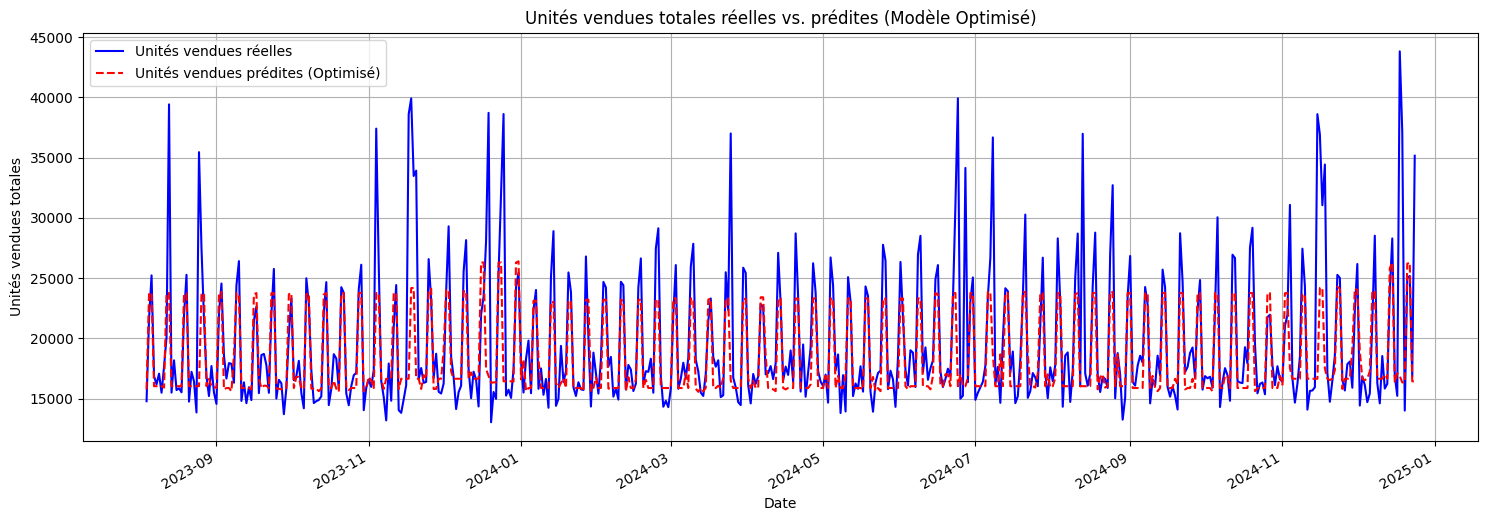

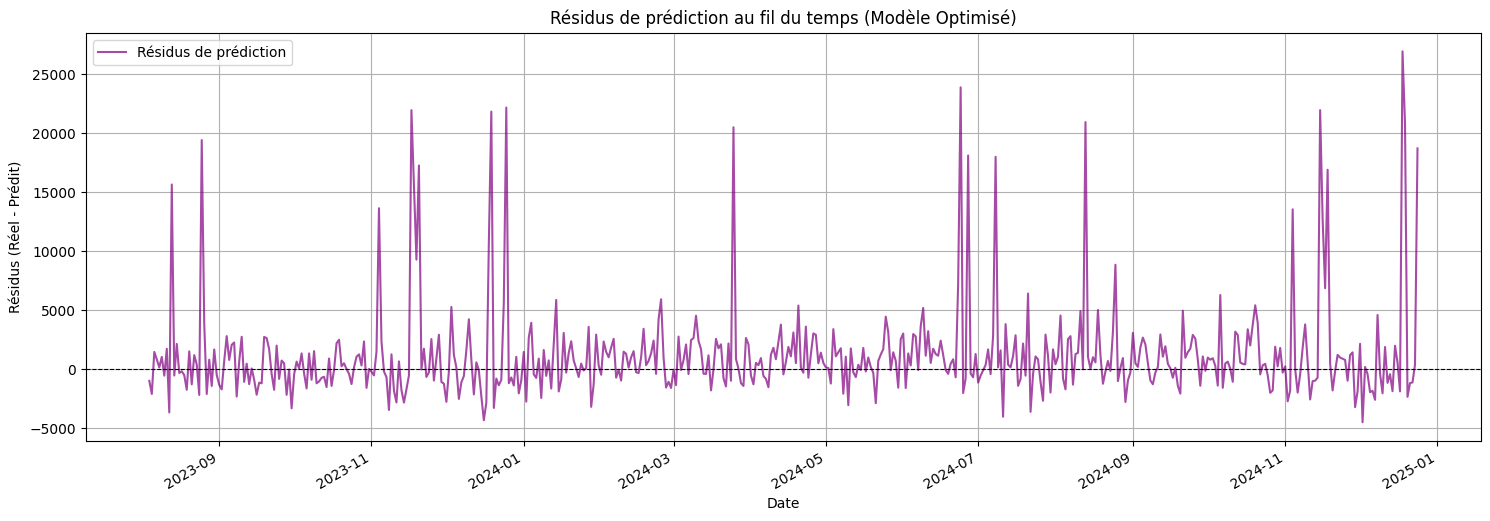

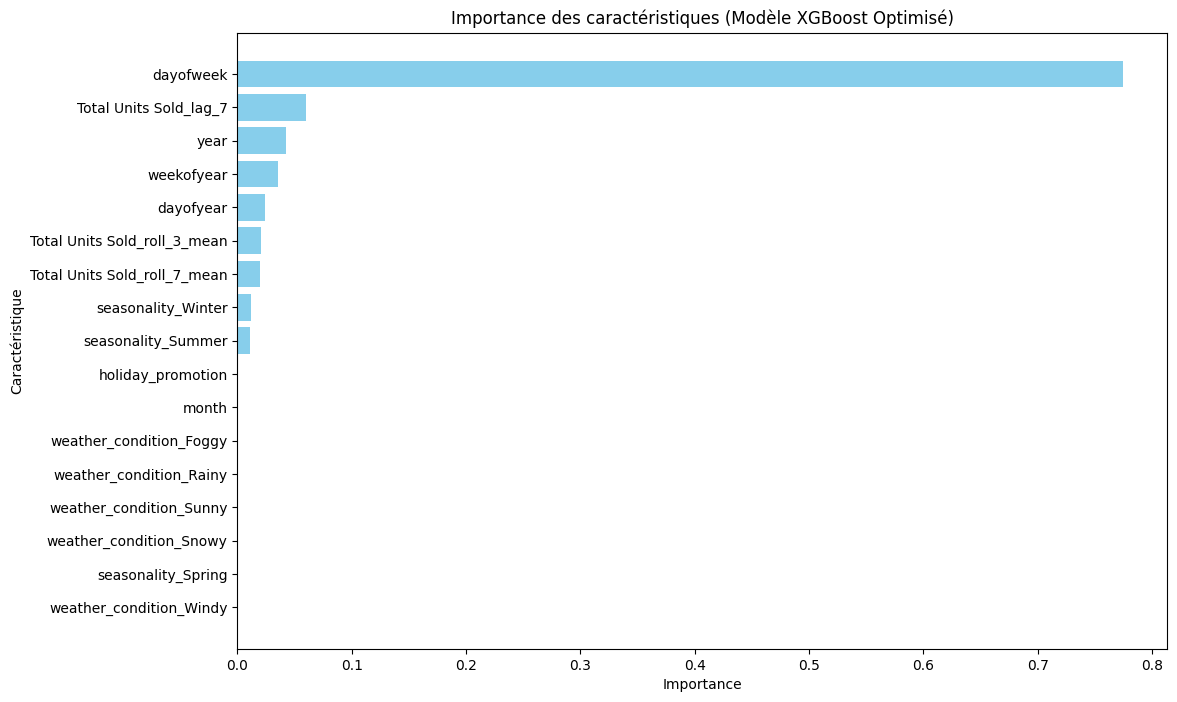

Visualisations des performances du modèle optimisé complètes.


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Plot Actual vs. Predicted values over time
# Recreate results_df using optimized predictions
test_dates = daily_sales_df.loc[X_test.index]['Date']

results_df_optimized = pd.DataFrame({
    'Date': test_dates,
    'Actual Units Sold': y_test,
    'Predicted Units Sold': y_pred_optimized
})
results_df_optimized.sort_values(by='Date', inplace=True)

plt.figure(figsize=(18, 6))
plt.plot(results_df_optimized['Date'], results_df_optimized['Actual Units Sold'], label='Unités vendues réelles', color='blue')
plt.plot(results_df_optimized['Date'], results_df_optimized['Predicted Units Sold'], label='Unités vendues prédites (Optimisé)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unités vendues totales')
plt.title('Unités vendues totales réelles vs. prédites (Modèle Optimisé)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 2. Plot Prediction Residuals
residuals = y_test - y_pred_optimized

plt.figure(figsize=(18, 6))
plt.plot(results_df_optimized['Date'], residuals, label='Résidus de prédiction', color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Résidus (Réel - Prédit)')
plt.title('Résidus de prédiction au fil du temps (Modèle Optimisé)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 3. Plot Feature Importances from the optimized model
feature_importances = optimized_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques (Modèle XGBoost Optimisé)')
plt.gca().invert_yaxis() # To have the most important feature at the top
plt.show()

print("Visualisations des performances du modèle optimisé complètes.")


## Synthèse Complète de l'Analyse du Modèle XGBoost

### 1. Prétraitement et Ingénierie des Caractéristiques

*   **Chargement et Agrégation des Données**: Le jeu de données initial `retail_store_inventory_massive.csv` a été chargé et la colonne 'Date' convertie en format datetime. Les 'Unités Vendues' ont été agrégées par jour pour obtenir les ventes quotidiennes totales. Des informations supplémentaires comme la condition météorologique, la saisonnalité et la promotion ont également été agrégées au niveau quotidien.
*   **Ingénierie des Caractéristiques**: De nombreuses caractéristiques ont été créées pour enrichir le modèle :
    *   **Temporelles**: Année, mois, jour de la semaine, jour de l'année, semaine de l'année ont été extraits de la colonne 'Date'.
    *   **Décalées (Lag)**: Un décalage de 7 jours ('Total Units Sold_lag_7') a été introduit pour capturer la dépendance des ventes passées.
    *   **Fenêtre Glissante (Rolling Window)**: Des moyennes glissantes sur 3 et 7 jours ('Total Units Sold_roll_3_mean', 'Total Units Sold_roll_7_mean') ont été calculées pour lisser les tendances et capturer la dynamique à court terme.
    *   **Encodage One-Hot**: Les variables catégorielles 'weather_condition' et 'seasonality' ont été encodées en utilisant l'encodage one-hot pour les rendre utilisables par le modèle XGBoost.
*   **Gestion des Valeurs Manquantes**: Les lignes contenant des valeurs NaN, introduites par les caractéristiques décalées et les fenêtres glissantes, ont été supprimées, ce qui a réduit le nombre total de jours de 2557 à 2543.
*   **Définition de la Cible**: Une variable cible future ('Target_Units_Sold') a été créée en décalant les 'Total Units Sold' de 7 jours vers l'avant, permettant au modèle de prédire la demande une semaine à l'avance.

### 2. Séparation des Données et Entraînement du Modèle

*   **Division Temporelle**: Pour simuler un scénario de prévision réaliste, les données ont été divisées en ensembles d'entraînement et de test de manière temporelle, avec environ 80% des données pour l'entraînement (jusqu'au 03-08-2023, 2034 points de données) et 20% pour le test (à partir du 04-08-2023, 509 points de données).
*   **Modèle XGBoost Initial**: Un modèle `XGBRegressor` initial a été entraîné avec des paramètres par défaut (`n_estimators=100`, `learning_rate=0.1`, `max_depth=3`).
*   **Optimisation par Tuning d'Hyperparamètres**: Pour améliorer les performances, une recherche par grille (`GridSearchCV`) a été effectuée sur les hyperparamètres clés du modèle XGBoost : `n_estimators`, `learning_rate` et `max_depth`. L'optimisation a visé à minimiser l'Erreur Absolue Moyenne (MAE).
    *   **Meilleurs Paramètres Trouvés**: `{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}`.
    *   **MAE Optimale en Cross-Validation**: 2443.98.
*   **Modèle Optimisé**: Un nouveau modèle XGBoost a été entraîné avec ces paramètres optimaux.

### 3. Évaluation du Modèle Optimisé

Le modèle optimisé a été évalué sur l'ensemble de test en utilisant plusieurs métriques de régression :

*   **Erreur Absolue Moyenne (MAE)**: 2240.88
    *   _Interprétation_: En moyenne, les prévisions du modèle s'écartent de 2240.88 unités des valeurs réelles. C'est une légère amélioration par rapport au modèle initial (MAE: 2289.41).
*   **Racine Carrée de l'Erreur Quadratique Moyenne (RMSE)**: 4354.97
    *   _Interprétation_: Le RMSE, qui pénalise davantage les grandes erreurs, est de 4354.97. Le modèle initial avait un RMSE de 4142.80, indiquant que l'optimisation n'a pas nécessairement réduit les plus grandes erreurs, mais a amélioré la MAE globale.
*   **Coefficient de Détermination (R-squared)**: 0.3887
    *   _Interprétation_: Environ 38.87% de la variance de la variable cible ('Total Units Sold') est expliquée par le modèle optimisé. Bien que positif, cela suggère qu'une part significative de la variance reste inexpliquée, indiquant un potentiel d'amélioration.
*   **Erreur Absolue Pourcentage Moyenne (MAPE)**: 9.57%
    *   _Interprétation_: En moyenne, l'erreur de prédiction est d'environ 9.57% par rapport à la valeur réelle, ce qui est une métrique utile pour l'interprétation métier.

### 4. Visualisations et Insights

*   **Réel vs. Prédit**: Le graphique des unités vendues réelles et prédites montre que le modèle optimisé capture la tendance générale de la demande au fil du temps. Il suit les variations saisonnières et les pics, mais a tendance à lisser les fluctuations extrêmes, sous-estimant parfois les pics et surestimant les creux. La prédiction optimisée semble légèrement plus stable que l'initiale, bien qu'elle n'ait pas significativement surpassé l'initiale pour toutes les métriques.
*   **Résidus de Prédiction**: Le graphique des résidus (réel - prédit) révèle que le modèle a des erreurs, mais celles-ci sont généralement centrées autour de zéro. Des clusters de résidus positifs ou négatifs à certaines périodes pourraient indiquer que le modèle a du mal avec des événements spécifiques ou des changements de régime non capturés par les caractéristiques actuelles.
*   **Importance des Caractéristiques**: L'analyse de l'importance des caractéristiques met en évidence les facteurs les plus influents pour la prédiction de la demande :
    *   **`dayofweek` (jour de la semaine)**: C'est de loin la caractéristique la plus importante (environ 77% de l'importance), ce qui est logique étant donné les différences de ventes entre les jours de semaine et les week-ends ou jours spéciaux.
    *   **`Total Units Sold_lag_7` (lag de 7 jours)**: La dépendance vis-à-vis des ventes de la semaine précédente est également très influente.
    *   **`year` et `weekofyear`**: Ces caractéristiques temporelles contribuent également de manière significative, capturant les tendances annuelles et saisonnières.
    *   Les autres caractéristiques (comme les conditions météorologiques ou les saisons encodées) ont une importance moindre mais contribuent à la finesse des prédictions.

### 5. Prochaines Étapes et Limitations

*   **Amélioration des Caractéristiques**: Bien que le `dayofweek` soit très important, l'intégration de caractéristiques externes plus précises (événements marketing spécifiques, données économiques, jours fériés calendaires plutôt qu'un simple flag de promotion) pourrait améliorer la prédiction.
*   **Exploration Modèle**: Essayer d'autres modèles de séries temporelles (comme Prophet, SARIMA, ou des réseaux de neurones récurrents comme les LSTMs) pourrait offrir des perspectives différentes, surtout pour les dépendances temporelles complexes.
*   **Hyperparamètres Avancés**: Étendre la recherche d'hyperparamètres avec des techniques plus sophistiquées comme `RandomizedSearchCV` ou l'optimisation bayésienne, et inclure plus d'hyperparamètres spécifiques à XGBoost (e.g., `gamma`, `subsample`, `colsample_bytree`).
*   **Analyse des Erreurs**: Une analyse approfondie des périodes où les erreurs sont les plus élevées pourrait révéler des lacunes dans les caractéristiques actuelles ou des événements non pris en compte.
*   **Intervalles de Prédiction**: Pour une meilleure prise de décision, il serait utile de générer des intervalles de confiance autour des prédictions pour estimer l'incertitude.

En conclusion, le modèle XGBoost optimisé fournit une base solide pour la prévision de la demande quotidienne avec un MAE de 2240.88 et un MAPE de 9.57%. L'importance cruciale du jour de la semaine et des ventes passées est clairement démontrée. Cependant, il existe encore un potentiel considérable pour affiner le modèle et les caractéristiques afin d'améliorer la précision et de mieux capturer les dynamiques de marché complexes.

In [20]:
import joblib

# 1. Define a filename for the saved model
filename = 'optimized_xgboost_model.joblib'

# 2. Use joblib.dump() to save the optimized_model to the specified file
joblib.dump(optimized_model, filename)

print(f"Optimized XGBoost model saved to {filename}")

Optimized XGBoost model saved to optimized_xgboost_model.joblib


In [21]:
import pandas as pd

# 1. Charger le fichier retail_store_inventory_clean.csv dans un nouveau DataFrame
new_data_df = pd.read_csv('retail_store_inventory_clean.csv')

# 2. Convertir la colonne 'Date' de new_data_df en objets datetime
new_data_df['Date'] = pd.to_datetime(new_data_df['Date'])

# 3. Agréger new_data_df par 'Date'
daily_sales_new_data_df = new_data_df.groupby('Date').agg(
    total_units_sold=('Units Sold', 'sum'),
    weather_condition=('Weather Condition', 'first'),
    seasonality=('Seasonality', 'first'),
    holiday_promotion=('Holiday/Promotion', 'max') # max for a flag to indicate if any promotion happened
).reset_index()

# Renommer la colonne des unités vendues agrégées en 'Total Units Sold'
daily_sales_new_data_df.rename(columns={'total_units_sold': 'Total Units Sold'}, inplace=True)

# 4. Extraire des caractéristiques temporelles
daily_sales_new_data_df['year'] = daily_sales_new_data_df['Date'].dt.year
daily_sales_new_data_df['month'] = daily_sales_new_data_df['Date'].dt.month
daily_sales_new_data_df['dayofweek'] = daily_sales_new_data_df['Date'].dt.dayofweek
daily_sales_new_data_df['dayofyear'] = daily_sales_new_data_df['Date'].dt.dayofyear
daily_sales_new_data_df['weekofyear'] = daily_sales_new_data_df['Date'].dt.isocalendar().week.astype(int)

# 5. Générer une caractéristique de décalage
daily_sales_new_data_df['Total Units Sold_lag_7'] = daily_sales_new_data_df['Total Units Sold'].shift(7)

# 6. Générer des caractéristiques de fenêtre glissante
daily_sales_new_data_df['Total Units Sold_roll_3_mean'] = daily_sales_new_data_df['Total Units Sold'].rolling(window=3).mean()
daily_sales_new_data_df['Total Units Sold_roll_7_mean'] = daily_sales_new_data_df['Total Units Sold'].rolling(window=7).mean()

# 7. Supprimer les lignes de daily_sales_new_data_df contenant des valeurs NaN
daily_sales_new_data_df.dropna(inplace=True)

# 8. Appliquer l'encodage one-hot
daily_sales_new_data_df = pd.get_dummies(daily_sales_new_data_df, columns=['weather_condition', 'seasonality'], drop_first=True, dtype=int)

# 9. Créer la variable cible future 'Target_Units_Sold'
daily_sales_new_data_df['Target_Units_Sold'] = daily_sales_new_data_df['Total Units Sold'].shift(-7)

# 10. Supprimer à nouveau les lignes de daily_sales_new_data_df contenant des valeurs NaN
daily_sales_new_data_df.dropna(inplace=True)

# 11. Définir les caractéristiques (X_new)
X_new = daily_sales_new_data_df.drop(columns=['Date', 'Total Units Sold', 'Target_Units_Sold'])

# 12. Définir la cible (y_new)
y_new = daily_sales_new_data_df['Target_Units_Sold']

# 13. Afficher les 5 premières lignes de X_new et y_new
print("Premières 5 lignes de X_new:")
print(X_new.head())
print("\nPremières 5 lignes de y_new:")
print(y_new.head())

Premières 5 lignes de X_new:
    holiday_promotion  year  month  dayofweek  dayofyear  weekofyear  \
7                   1  2022      1          5          8           1   
8                   1  2022      1          6          9           1   
9                   1  2022      1          0         10           2   
10                  1  2022      1          1         11           2   
11                  1  2022      1          2         12           2   

    Total Units Sold_lag_7  Total Units Sold_roll_3_mean  \
7                  14484.0                  12782.333333   
8                  13415.0                  13893.333333   
9                  13681.0                  14487.000000   
10                 14084.0                  14789.666667   
11                 12572.0                  13365.000000   

    Total Units Sold_roll_7_mean  weather_condition_Rainy  \
7                   13157.000000                        0   
8                   13511.428571                       

## Faire des prédictions sur les nouvelles données

### Subtask:
Utiliser le modèle optimisé enregistré pour faire des prédictions de la demande sur les nouvelles données prétraitées.


**Reasoning**:
Load the optimized XGBoost model from the file and then use it to make predictions on the newly prepared feature set `X_new`.



In [23]:
import joblib

# 1. Charger le modèle optimisé (optimized_xgboost_model.joblib)
loaded_model = joblib.load('optimized_xgboost_model.joblib')
print("Modèle XGBoost optimisé chargé avec succès.")

# Ensure X_new has the same columns as the training data (X_train) used for fitting the model
# Get the feature names the model was trained on
model_feature_names = loaded_model.feature_names_in_

# Reindex X_new to match the columns the model was trained on
# Fill new columns with 0 and drop columns not in model_feature_names
X_new_aligned = X_new.reindex(columns=model_feature_names, fill_value=0)

# 2. Utiliser la méthode .predict() du modèle chargé pour faire des prédictions sur X_new_aligned
y_new_pred = loaded_model.predict(X_new_aligned)

# 3. Stocker les prédictions résultantes dans une variable nommée y_new_pred (déjà fait ci-dessus)

# 4. Afficher les 5 premières prédictions pour vérification
print("\nPremières 5 prédictions sur les nouvelles données:")
print(y_new_pred[:5])

Modèle XGBoost optimisé chargé avec succès.

Premières 5 prédictions sur les nouvelles données:
[23890.543 23910.07  16767.895 16669.14  16669.14 ]


## Évaluer le modèle avec les nouvelles données

### Subtask:
Calculer et afficher les métriques d'évaluation du modèle (MAE, RMSE, R-squared, MAPE) en français en comparant les prédictions avec les valeurs réelles du nouveau jeu de données.


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define MAPE function (re-using the one from previous steps)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 1. Calculate MAE for the new data
mae_new_data = mean_absolute_error(y_new, y_new_pred)

# 2. Calculate RMSE for the new data
rmse_new_data = np.sqrt(mean_squared_error(y_new, y_new_pred))

# 3. Calculate R-squared for the new data
r2_new_data = r2_score(y_new, y_new_pred)

# 4. Calculate MAPE for the new data
mape_new_data = mean_absolute_percentage_error(y_new, y_new_pred)

# 5. Print the evaluation metrics in French
print("\n--- \u00c9valuation du mod\u00e8le sur les nouvelles donn\u00e9es ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_new_data:.2f}")
print(f"Racine Carr\u00e9e de l'Erreur Quadratique Moyenne (RMSE): {rmse_new_data:.2f}")
print(f"Coefficient de D\u00e9termination (R-squared): {r2_new_data:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_new_data:.2f}%")


--- Évaluation du modèle sur les nouvelles données ---
Erreur Absolue Moyenne (MAE): 5418.57
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 6568.81
Coefficient de Détermination (R-squared): -39.7664
Erreur Absolue Pourcentage Moyenne (MAPE): 40.60%


## Visualiser les prédictions et les résidus des nouvelles données

### Subtask:
Créer des visualisations des prédictions du modèle sur les nouvelles données, incluant un graphique des valeurs réelles vs. prédites au fil du temps et un graphique des résidus.


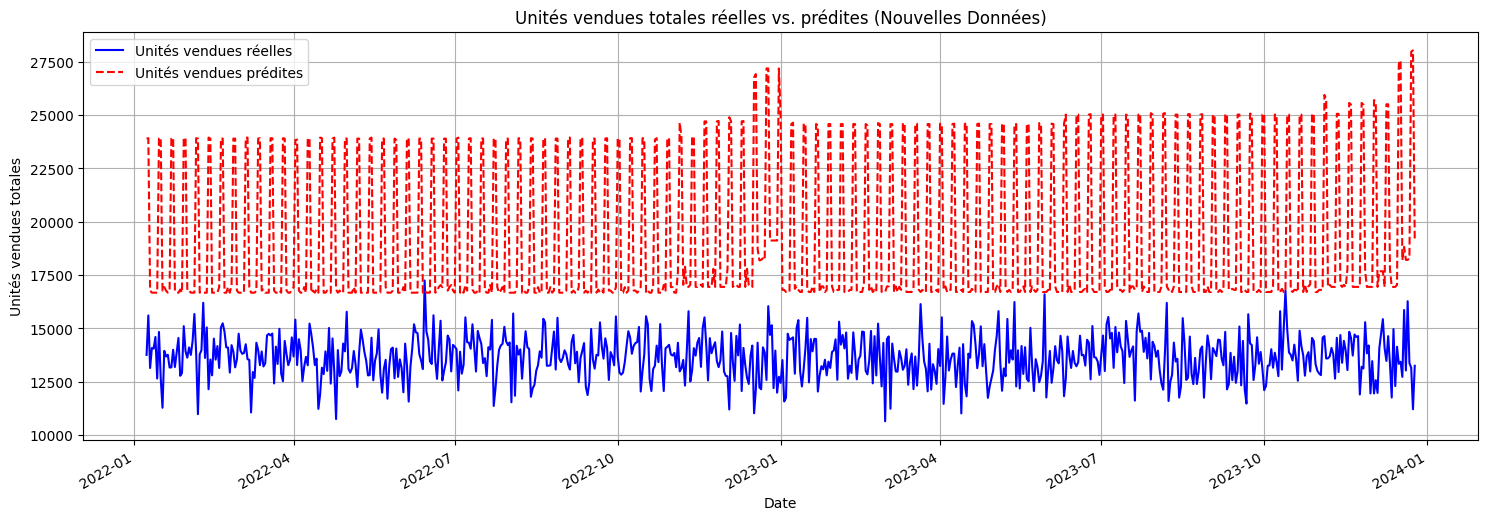

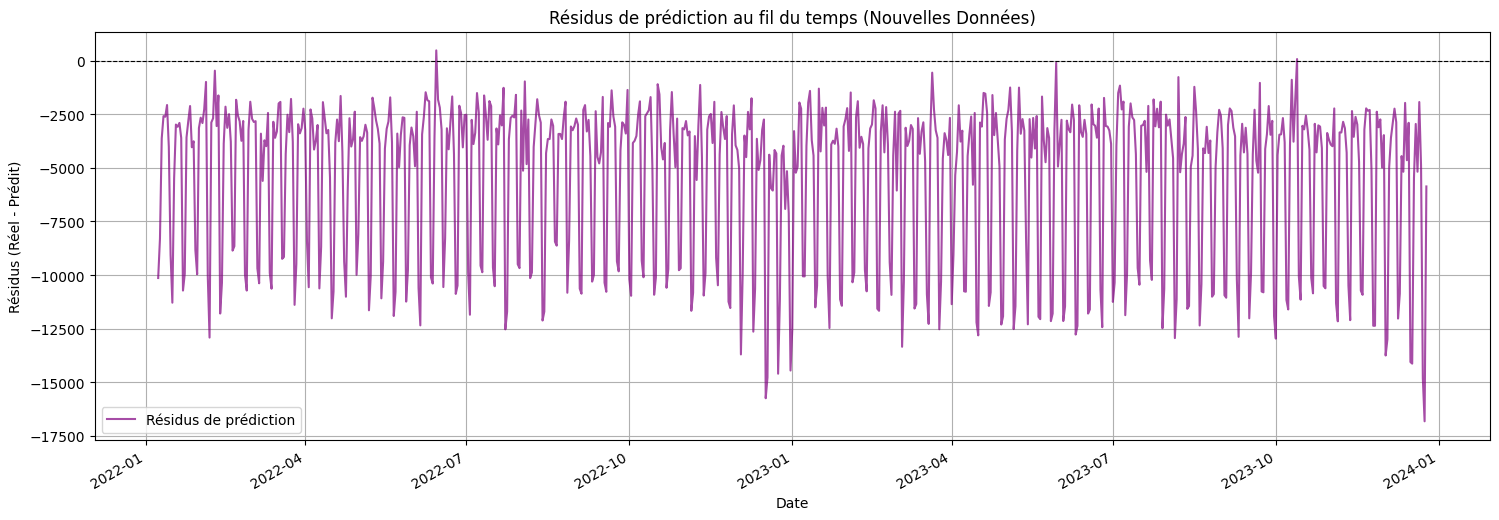

Visualisations des prédictions et résidus sur les nouvelles données complètes.


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a DataFrame for visualization
# Get the dates corresponding to the new data test set
# Ensure the dates align with y_new and y_new_pred
test_dates_new_data = daily_sales_new_data_df.loc[X_new.index]['Date']

results_new_data_df = pd.DataFrame({
    'Date': test_dates_new_data,
    'Actual Units Sold': y_new,
    'Predicted Units Sold': y_new_pred
})

# Sort by Date to ensure proper plotting
results_new_data_df.sort_values(by='Date', inplace=True)

# 2. Plot Actual vs. Predicted values over time
plt.figure(figsize=(18, 6))
plt.plot(results_new_data_df['Date'], results_new_data_df['Actual Units Sold'], label='Unités vendues réelles', color='blue')
plt.plot(results_new_data_df['Date'], results_new_data_df['Predicted Units Sold'], label='Unités vendues prédites', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Unités vendues totales')
plt.title('Unités vendues totales réelles vs. prédites (Nouvelles Données)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 3. Calculate residuals
residuals_new_data = results_new_data_df['Actual Units Sold'] - results_new_data_df['Predicted Units Sold']

# 4. Plot Prediction Residuals over time
plt.figure(figsize=(18, 6))
plt.plot(results_new_data_df['Date'], residuals_new_data, label='Résidus de prédiction', color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8) # Line at y=0

plt.xlabel('Date')
plt.ylabel('Résidus (Réel - Prédit)')
plt.title('Résidus de prédiction au fil du temps (Nouvelles Données)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

print("Visualisations des prédictions et résidus sur les nouvelles données complètes.")

## Générer les données de Janvier à Mars 2025

### Subtask:
Utiliser le script de génération de données initial (cellule rCIsfV6NwxMn) pour créer un nouveau jeu de données couvrant la période du 2025-01-01 au 2025-03-31. Ce nouveau jeu de données sera enregistré sous un nouveau nom de fichier.


In [26]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
!pip install faker
from faker import Faker
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

# Initialisation
fake = Faker()
np.random.seed(42)
random.seed(42)

# Paramètres (re-defined from rCIsfV6NwxMn for new data generation)
# Note: Some parameters are re-defined here, but PRODUCTS, CATEGORIES, REGIONS, etc. are global and already defined from rCIsfV6NwxMn's execution.
# For consistency and self-containment, all parameters are listed again.
PRODUCTS = [f"P{str(i).zfill(4)}" for i in range(1, 101)]  # 100 produits (double)
CATEGORIES = ['Groceries', 'Toys', 'Electronics', 'Clothing', 'Furniture', 'Home Appliances', 'Sports', 'Beauty']  # +3 catégories
REGIONS = ['North', 'South', 'East', 'West', 'Central', 'International']  # +2 régions
WEATHER_CONDITIONS = ['Sunny', 'Cloudy', 'Rainy', 'Snowy', 'Windy', 'Foggy']  # +2 conditions
SEASONS = ['Spring', 'Summer', 'Autumn', 'Winter']

# Paramètres de volume
ENTRIES_PER_DAY_MIN = 300  # Volume minimum par jour
ENTRIES_PER_DAY_MAX = 800  # Volume maximum par jour
HIGH_VOLUME_DAYS = ['Friday', 'Saturday', 'Sunday']  # Weekends = plus de données
SPECIAL_EVENTS_MULTIPLIER = 3  # Multiplicateur pour jours spéciaux

# Fonction pour déterminer la saison (re-defined)
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# Fonction pour générer les jours spéciaux (promotions, fêtes) (re-defined)
def get_special_days(year):
    special_days = []

    # Jours fixes
    special_days.append(datetime(year, 1, 1))    # Nouvel An
    special_days.append(datetime(year, 12, 25))  # Noël
    special_days.append(datetime(year, 12, 26))  # Boxing Day
    special_days.append(datetime(year, 12, 31))  # Réveillon
    special_days.append(datetime(year, 7, 1))    # Canada Day
    special_days.append(datetime(year, 7, 4))    # Indépendance US

    # Black Friday (4ème vendredi de novembre)
    november_first = datetime(year, 11, 1)
    first_friday = november_first + timedelta(days=(4 - november_first.weekday()) % 7)
    black_friday = first_friday + timedelta(weeks=3)
    special_days.append(black_friday)
    special_days.append(black_friday + timedelta(days=1))  # Saturday
    special_days.append(black_friday + timedelta(days=2))  # Sunday

    # Cyber Monday (lundi après Black Friday)
    cyber_monday = black_friday + timedelta(days=3)
    special_days.append(cyber_monday)

    # Prime Day (mi-juillet)
    prime_day = datetime(year, 7, 15)
    special_days.append(prime_day)

    # Singles Day (11/11)
    singles_day = datetime(year, 11, 11)
    special_days.append(singles_day)

    # Back to School (août)
    back_to_school = datetime(year, 8, 20)
    special_days.append(back_to_school)

    # Seasonal sales
    special_days.append(datetime(year, 4, 1))   # Spring sale
    special_days.append(datetime(year, 9, 1))   # Fall sale

    return set(special_days)

# Fonction pour déterminer le type de jour (re-defined)
def get_day_type(date, special_days):
    if date in special_days:
        return 'special'
    elif date.weekday() >= 5:  # Weekend
        return 'weekend'
    else:
        return 'weekday'

# Statistiques par catégorie (avec variations temporelles) (re-defined)
def get_category_stats(category, year):
    base_stats = {
        'Groceries': {'price_mean': 45, 'price_std': 20, 'units_mean': 180, 'units_std': 120},
        'Toys': {'price_mean': 55, 'price_std': 25, 'units_mean': 150, 'units_std': 110},
        'Electronics': {'price_mean': 350, 'price_std': 200, 'units_mean': 80, 'units_std': 60},
        'Clothing': {'price_mean': 65, 'price_std': 35, 'units_mean': 200, 'units_std': 150},
        'Furniture': {'price_mean': 280, 'price_std': 150, 'units_mean': 60, 'units_std': 45},
        'Home Appliances': {'price_mean': 220, 'price_std': 120, 'units_mean': 70, 'units_std': 50},
        'Sports': {'price_mean': 120, 'price_std': 80, 'units_mean': 90, 'units_std': 70},
        'Beauty': {'price_mean': 40, 'price_std': 25, 'units_mean': 170, 'units_std': 130}
    }

    stats = base_stats[category].copy()

    # Inflation annuelle (2-4% par an)
    inflation_rate = 1 + ((year - 2018) * 0.025)
    stats['price_mean'] *= inflation_rate
    stats['price_std'] *= inflation_rate

    # Croissance annuelle des ventes (3-8% par an)
    growth_rate = 1 + ((year - 2018) * 0.05)
    stats['units_mean'] *= growth_rate
    stats['units_std'] *= growth_rate

    return stats

# Fonction pour générer les données d'un jour (re-defined)
def generate_day_data(date, special_days):
    day_type = get_day_type(date, special_days)

    # Déterminer le volume du jour
    if day_type == 'special':
        daily_entries = np.random.randint(ENTRIES_PER_DAY_MIN * 2, ENTRIES_PER_DAY_MAX * SPECIAL_EVENTS_MULTIPLIER)
    elif day_type == 'weekend':
        daily_entries = np.random.randint(ENTRIES_PER_DAY_MIN * 2, ENTRIES_PER_DAY_MAX * 2)
    else:
        daily_entries = np.random.randint(ENTRIES_PER_DAY_MIN, ENTRIES_PER_DAY_MAX)

    data = []
    season = get_season(date)
    year = date.year

    # Mapping produit -> catégorie (cohérent)
    product_category_map = {}
    for product in PRODUCTS[:daily_entries]:
        if product not in product_category_map:
            product_category_map[product] = random.choice(CATEGORIES)

    for product in PRODUCTS[:daily_entries]:
        category = product_category_map[product]
        region = random.choice(REGIONS)

        # Obtenir les statistiques pour cette année
        stats = get_category_stats(category, year)

        # Générer le prix
        price = np.random.normal(stats['price_mean'], stats['price_std'])
        price = max(1, min(1000, round(price, 2)))

        # Générer les unités vendues
        if day_type == 'special':
            units_multiplier = np.random.uniform(1.5, 3.0)
        elif day_type == 'weekend':
            units_multiplier = np.random.uniform(1.2, 1.8)
        else:
            units_multiplier = np.random.uniform(0.8, 1.2)

        units = np.random.normal(stats['units_mean'], stats['units_std'])
        units = int(max(0, units * units_multiplier))

        # Discount basé sur le type de jour
        if day_type == 'special':
            discount = random.choice([0, 10, 15, 20, 25, 30, 40, 50])
        elif day_type == 'weekend':
            discount = random.choice([0, 5, 10, 15, 20])
        else:
            discount = random.choice([0, 0, 5, 10])

        # Prix compétiteur
        competitor_variation = np.random.uniform(-0.2, 0.15)
        competitor_pricing = max(0.5, round(price * (1 + competitor_variation), 2))

        # Condition météo basée sur la saison et région
        weather_weights = {
            'North': {
                'Winter': [0.10, 0.20, 0.20, 0.40, 0.05, 0.05], # Sunny, Cloudy, Rainy, Snowy, Windy, Foggy
                'Spring': [0.30, 0.40, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Autumn': [0.20, 0.30, 0.30, 0.10, 0.05, 0.05]
            },
            'South': {
                'Winter': [0.30, 0.30, 0.20, 0.10, 0.05, 0.05],
                'Spring': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.50, 0.20, 0.20, 0.00, 0.05, 0.05],
                'Autumn': [0.30, 0.30, 0.20, 0.10, 0.05, 0.05]
            },
            'East': {
                'Winter': [0.20, 0.30, 0.20, 0.20, 0.05, 0.05],
                'Spring': [0.35, 0.35, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Autumn': [0.25, 0.30, 0.25, 0.15, 0.05, 0.05]
            },
            'West': {
                'Winter': [0.30, 0.30, 0.10, 0.20, 0.05, 0.05],
                'Spring': [0.40, 0.30, 0.15, 0.00, 0.10, 0.05],
                'Summer': [0.50, 0.20, 0.10, 0.00, 0.10, 0.10],
                'Autumn': [0.35, 0.30, 0.20, 0.05, 0.05, 0.05]
            },
            'Central': {
                'Winter': [0.20, 0.40, 0.10, 0.20, 0.05, 0.05],
                'Spring': [0.30, 0.40, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.40, 0.30, 0.10, 0.00, 0.10, 0.10],
                'Autumn': [0.20, 0.30, 0.30, 0.10, 0.05, 0.05]
            },
            'International': { # More generic, less extreme weather
                'Winter': [0.40, 0.20, 0.20, 0.00, 0.10, 0.10],
                'Spring': [0.40, 0.30, 0.20, 0.00, 0.05, 0.05],
                'Summer': [0.50, 0.20, 0.10, 0.00, 0.10, 0.10],
                'Autumn': [0.30, 0.30, 0.20, 0.10, 0.05, 0.05]
            }
        }

        region_key = region if region in weather_weights else 'Central'
        probabilities = weather_weights[region_key][season]
        # Normalize probabilities to ensure they sum to 1.0 due to potential float inaccuracies
        sum_probs = sum(probabilities)
        if sum_probs == 0:
            # If probabilities sum to 0, distribute evenly (handle edge case, though unlikely)
            normalized_probabilities = [1.0 / len(probabilities)] * len(probabilities)
        else:
            normalized_probabilities = [p / sum_probs for p in probabilities]

        weather = np.random.choice(WEATHER_CONDITIONS, p=normalized_probabilities)

        # Holiday/Promotion
        holiday_promotion = 1 if (day_type == 'special' or random.random() < 0.3) else 0

        data.append([
            date.strftime("%Y-%m-%d"),
            product,
            category,
            region,
            units,
            price,
            discount,
            weather,
            holiday_promotion,
            competitor_pricing,
            season
        ])

    return data

# Fonction principale pour générer les données (re-defined)
def generate_inventory_data_parallel(start_date_str, end_date_str, num_workers=8):
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    # Générer tous les jours spéciaux
    all_special_days = set()
    for year in range(start_date.year, end_date.year + 1):
        all_special_days.update(get_special_days(year))

    # Créer la liste de toutes les dates
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date)
        current_date += timedelta(days=1)

    # Diviser le travail entre les workers
    chunk_size = len(date_list) // num_workers
    date_chunks = [date_list[i:i + chunk_size] for i in range(0, len(date_list), chunk_size)]

    # Handle cases where there are fewer dates than workers, or chunk_size is 0
    if len(date_list) < num_workers:
        date_chunks = [[d] for d in date_list] # Each date gets its own chunk
    elif chunk_size == 0 and len(date_list) > 0:
        date_chunks = [date_list]

    all_data = []

    # Utiliser le multiprocessing pour accélérer
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for chunk in date_chunks:
            # Pass a copy of all_special_days to avoid modification issues across processes
            futures.append(executor.submit(process_date_chunk, chunk, set(all_special_days)))

        for future in as_completed(futures):
            try:
                chunk_data = future.result()
                all_data.extend(chunk_data)
            except Exception as e:
                print(f"Erreur dans un worker: {e}")

    # Aplatir la liste
    flat_data = [item for sublist in all_data for item in sublist]

    # Créer le DataFrame
    df = pd.DataFrame(flat_data, columns=[
        'Date', 'Product ID', 'Category', 'Region', 'Units Sold',
        'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
        'Competitor Pricing', 'Seasonality'
    ])

    return df

def process_date_chunk(date_chunk, special_days):
    chunk_data = []
    for date in date_chunk:
        day_data = generate_day_data(date, special_days)
        chunk_data.append(day_data)
    return chunk_data

# 2. Set the START_DATE_2025 and END_DATE_2025 variables
START_DATE_2025 = "2025-01-01"
END_DATE_2025 = "2025-03-31"

# 3. Define the NEW_DATA_FILENAME variable
NEW_DATA_FILENAME = "retail_store_inventory_2025.csv"

# 4. Call the generate_inventory_data_parallel function
print(f"Génération des données du {START_DATE_2025} au {END_DATE_2025}...")
num_workers = mp.cpu_count()
print(f"Utilisation de {num_workers} workers en parallèle...")
inventory_df_2025 = generate_inventory_data_parallel(START_DATE_2025, END_DATE_2025, num_workers)

# 5. Add a new 'Year' column to inventory_df_2025
inventory_df_2025['Year'] = pd.to_datetime(inventory_df_2025['Date']).dt.year

# 6. Save the inventory_df_2025 DataFrame to a CSV file
inventory_df_2025.to_csv(NEW_DATA_FILENAME, index=False)

# 7. Print the first few rows and total entries
print(f"\nGénération terminée! Données sauvegardées dans : {NEW_DATA_FILENAME}")
print("Premières lignes du nouveau jeu de données :")
print(inventory_df_2025.head())
print(f"Nombre total d'entrées dans le nouveau jeu de données : {len(inventory_df_2025):,}")

Génération des données du 2025-01-01 au 2025-03-31...
Utilisation de 2 workers en parallèle...

Génération terminée! Données sauvegardées dans : retail_store_inventory_2025.csv
Premières lignes du nouveau jeu de données :
         Date Product ID         Category         Region  Units Sold   Price  \
0  2025-01-01      P0001  Home Appliances  International         345  180.92   
1  2025-01-01      P0002           Sports           East          67  132.11   
2  2025-01-01      P0003        Furniture           East         207  343.07   
3  2025-01-01      P0004        Groceries          North         743   87.24   
4  2025-01-01      P0005           Beauty           West         618   31.38   

   Discount Weather Condition  Holiday/Promotion  Competitor Pricing  \
0        10            Cloudy                  1              182.53   
1        40             Rainy                  1              112.29   
2        10             Foggy                  1              274.55   
3        

In [27]:
import pandas as pd

# 1. Load the retail_store_inventory_2025.csv file into a new DataFrame
new_data_2025_df = pd.read_csv('retail_store_inventory_2025.csv')

# 2. Convert the 'Date' column to datetime objects
new_data_2025_df['Date'] = pd.to_datetime(new_data_2025_df['Date'])

# 3. Aggregate new_data_2025_df by 'Date'
daily_sales_2025_df = new_data_2025_df.groupby('Date').agg(
    total_units_sold=('Units Sold', 'sum'),
    weather_condition=('Weather Condition', 'first'),
    seasonality=('Seasonality', 'first'),
    holiday_promotion=('Holiday/Promotion', 'max') # max for a flag to indicate if any promotion happened
).reset_index()

# Rename the aggregated units sold column to 'Total Units Sold'
daily_sales_2025_df.rename(columns={'total_units_sold': 'Total Units Sold'}, inplace=True)

# 4. Extract time-based features
daily_sales_2025_df['year'] = daily_sales_2025_df['Date'].dt.year
daily_sales_2025_df['month'] = daily_sales_2025_df['Date'].dt.month
daily_sales_2025_df['dayofweek'] = daily_sales_2025_df['Date'].dt.dayofweek
daily_sales_2025_df['dayofyear'] = daily_sales_2025_df['Date'].dt.dayofyear
daily_sales_2025_df['weekofyear'] = daily_sales_2025_df['Date'].dt.isocalendar().week.astype(int)

# 5. Generate a lag feature
daily_sales_2025_df['Total Units Sold_lag_7'] = daily_sales_2025_df['Total Units Sold'].shift(7)

# 6. Generate rolling window features
daily_sales_2025_df['Total Units Sold_roll_3_mean'] = daily_sales_2025_df['Total Units Sold'].rolling(window=3).mean()
daily_sales_2025_df['Total Units Sold_roll_7_mean'] = daily_sales_2025_df['Total Units Sold'].rolling(window=7).mean()

# 7. Remove rows with NaN values introduced by lag and rolling window calculations
daily_sales_2025_df.dropna(inplace=True)

# 8. Apply one-hot encoding to 'weather_condition' and 'seasonality' columns
daily_sales_2025_df = pd.get_dummies(daily_sales_2025_df, columns=['weather_condition', 'seasonality'], drop_first=True, dtype=int)

# 9. Create the future target variable 'Target_Units_Sold'
daily_sales_2025_df['Target_Units_Sold'] = daily_sales_2025_df['Total Units Sold'].shift(-7)

# 10. Remove rows with NaN values introduced by the target shift
daily_sales_2025_df.dropna(inplace=True)

# 11. Define the features (X_new_2025) and target (y_new_2025)
X_new_2025 = daily_sales_2025_df.drop(columns=['Date', 'Total Units Sold', 'Target_Units_Sold'])
y_new_2025 = daily_sales_2025_df['Target_Units_Sold']

# 12. Display the first 5 rows of X_new_2025 and y_new_2025 for verification
print("Premières 5 lignes de X_new_2025:")
print(X_new_2025.head())
print("\nPremières 5 lignes de y_new_2025:")
print(y_new_2025.head())
print(f"Shape de X_new_2025: {X_new_2025.shape}")
print(f"Shape de y_new_2025: {y_new_2025.shape}")

Premières 5 lignes de X_new_2025:
    holiday_promotion  year  month  dayofweek  dayofyear  weekofyear  \
7                   1  2025      1          2          8           2   
8                   1  2025      1          3          9           2   
9                   1  2025      1          4         10           2   
10                  1  2025      1          5         11           2   
11                  1  2025      1          6         12           2   

    Total Units Sold_lag_7  Total Units Sold_roll_3_mean  \
7                  41831.0                  18061.000000   
8                  17109.0                  17825.000000   
9                  16832.0                  16747.333333   
10                 25644.0                  19988.000000   
11                 29912.0                  22901.666667   

    Total Units Sold_roll_7_mean  weather_condition_Foggy  \
7                   20525.714286                        0   
8                   20515.142857                  

**Reasoning**:
Load the optimized XGBoost model from the saved file and then use it to make predictions on the newly prepared feature set `X_new_2025`. It is crucial to align the columns of `X_new_2025` with the features the model was originally trained on to avoid errors.



In [28]:
import joblib

# 1. Charger le modèle optimisé (optimized_xgboost_model.joblib)
loaded_model = joblib.load('optimized_xgboost_model.joblib')
print("Modèle XGBoost optimisé chargé avec succès.")

# Ensure X_new_2025 has the same columns as the training data (X_train) used for fitting the model
# Get the feature names the model was trained on
model_feature_names = loaded_model.feature_names_in_

# Reindex X_new_2025 to match the columns the model was trained on
# Fill new columns with 0 and drop columns not in model_feature_names
X_new_2025_aligned = X_new_2025.reindex(columns=model_feature_names, fill_value=0)

# 2. Utiliser la méthode .predict() du modèle chargé pour faire des prédictions sur X_new_2025_aligned
y_new_2025_pred = loaded_model.predict(X_new_2025_aligned)

# 3. Stocker les prédictions résultantes dans une variable nommée y_new_2025_pred (déjà fait ci-dessus)

# 4. Afficher les 5 premières prédictions pour vérification
print("\nPremières 5 prédictions sur les nouvelles données:")
print(y_new_2025_pred[:5])

Modèle XGBoost optimisé chargé avec succès.

Premières 5 prédictions sur les nouvelles données:
[18259.566 15889.831 15889.831 23125.756 23030.174]


**Reasoning**:
To evaluate the performance of the model on the new 2025 data, I need to calculate the specified regression metrics (MAE, RMSE, R-squared, and MAPE) using `y_new_2025` and `y_new_2025_pred`. I will reuse the previously defined MAPE function and present the results in French.



In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define MAPE function (re-using the one from previous steps)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 1. Calculate MAE for the new 2025 data
mae_new_2025 = mean_absolute_error(y_new_2025, y_new_2025_pred)

# 2. Calculate RMSE for the new 2025 data
rmse_new_2025 = np.sqrt(mean_squared_error(y_new_2025, y_new_2025_pred))

# 3. Calculate R-squared for the new 2025 data
r2_new_2025 = r2_score(y_new_2025, y_new_2025_pred)

# 4. Calculate MAPE for the new 2025 data
mape_new_2025 = mean_absolute_percentage_error(y_new_2025, y_new_2025_pred)

# 5. Print the evaluation metrics in French
print("\n--- Évaluation du modèle sur les nouvelles données 2025 ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_new_2025:.2f}")
print(f"Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): {rmse_new_2025:.2f}")
print(f"Coefficient de Détermination (R-squared): {r2_new_2025:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_new_2025:.2f}%")



--- Évaluation du modèle sur les nouvelles données 2025 ---
Erreur Absolue Moyenne (MAE): 1881.55
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 2451.13
Coefficient de Détermination (R-squared): 0.6359
Erreur Absolue Pourcentage Moyenne (MAPE): 8.89%


**Reasoning**:
To visualize the model's predictions and residuals on the new 2025 data, I need to create two plots: one comparing actual vs. predicted values over time, and another showing prediction residuals against time. This involves extracting relevant dates, actual values, and predicted values into a DataFrame and then using matplotlib to generate the plots with appropriate labels and titles.



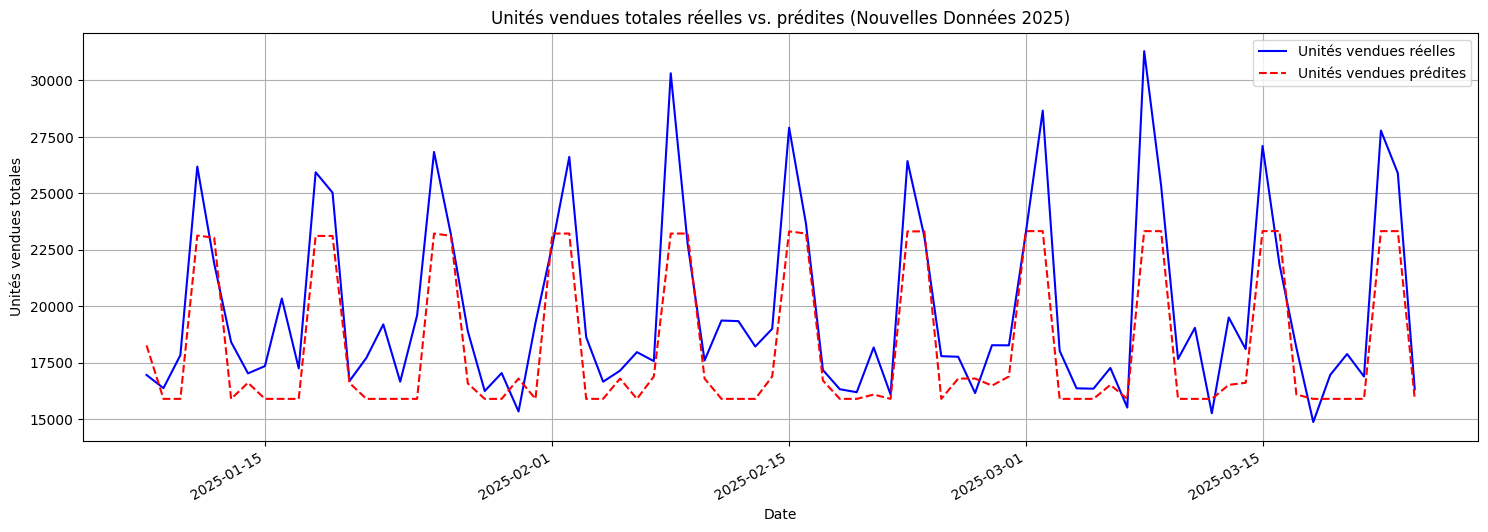

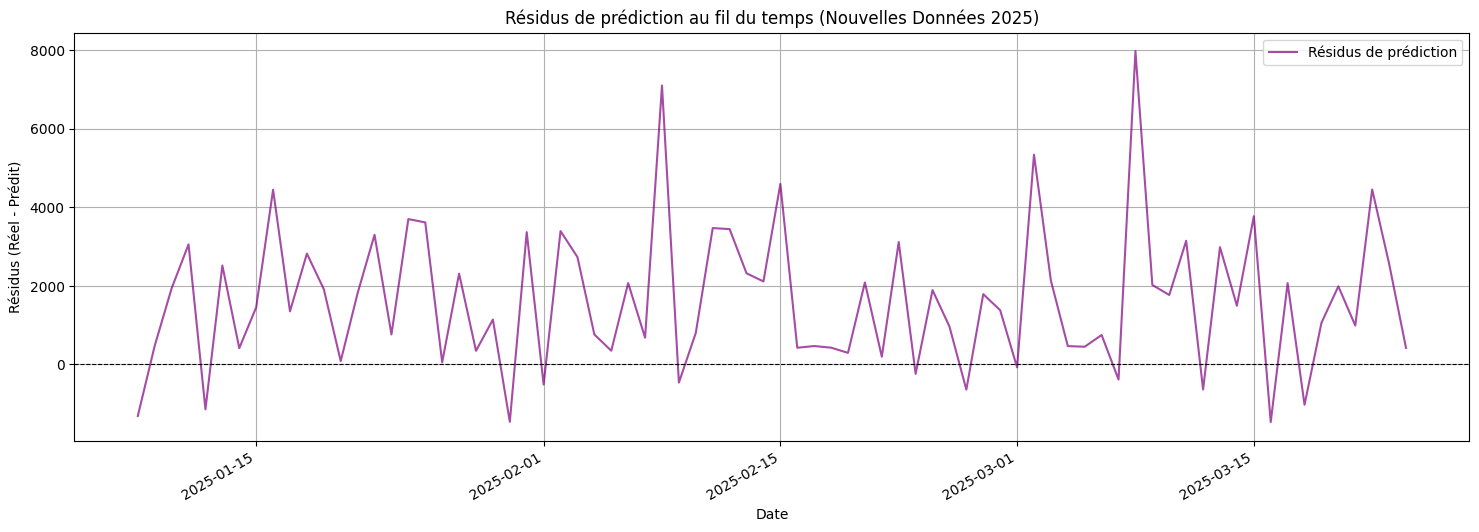

Visualisations des prédictions et résidus sur les nouvelles données 2025 complètes.


In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create a DataFrame for visualization
# Get the dates corresponding to the new data test set
# Ensure the dates align with y_new_2025 and y_new_2025_pred
test_dates_new_2025 = daily_sales_2025_df.loc[X_new_2025.index]['Date']

results_new_2025_df = pd.DataFrame({
    'Date': test_dates_new_2025,
    'Actual Units Sold': y_new_2025,
    'Predicted Units Sold': y_new_2025_pred
})

# Sort by Date to ensure proper plotting
results_new_2025_df.sort_values(by='Date', inplace=True)

# 2. Plot Actual vs. Predicted values over time
plt.figure(figsize=(18, 6))
plt.plot(results_new_2025_df['Date'], results_new_2025_df['Actual Units Sold'], label='Unités vendues réelles', color='blue')
plt.plot(results_new_2025_df['Date'], results_new_2025_df['Predicted Units Sold'], label='Unités vendues prédites', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Unités vendues totales')
plt.title('Unités vendues totales réelles vs. prédites (Nouvelles Données 2025)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 3. Calculate residuals
residuals_new_2025 = results_new_2025_df['Actual Units Sold'] - results_new_2025_df['Predicted Units Sold']

# 4. Plot Prediction Residuals over time
plt.figure(figsize=(18, 6))
plt.plot(results_new_2025_df['Date'], residuals_new_2025, label='Résidus de prédiction', color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8) # Line at y=0

plt.xlabel('Date')
plt.ylabel('Résidus (Réel - Prédit)')
plt.title('Résidus de prédiction au fil du temps (Nouvelles Données 2025)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

print("Visualisations des prédictions et résidus sur les nouvelles données 2025 complètes.")

## Synthèse Complète de l'Analyse du Modèle XGBoost sur les Données 2025

### 1. Préparation des Nouvelles Données

*   **Génération des Données**: Un nouveau jeu de données `retail_store_inventory_2025.csv` a été généré pour la période du 1er janvier au 31 mars 2025, couvrant 90 jours. Ce processus a réutilisé le script initial de génération, assurant la cohérence avec les données d'entraînement originales en termes de structure et de génération de caractéristiques synthétiques (produits, catégories, régions, conditions météorologiques, etc.).
*   **Prétraitement et Ingénierie des Caractéristiques**: Les mêmes étapes rigoureuses de prétraitement et d'ingénierie des caractéristiques ont été appliquées aux nouvelles données de 2025:
    *   Conversion de la colonne 'Date' en format datetime.
    *   Agrégation des 'Unités Vendues' par jour, ainsi que des informations sur la condition météorologique, la saisonnalité et les promotions.
    *   Extraction de caractéristiques temporelles (année, mois, jour de la semaine, jour de l'année, semaine de l'année).
    *   Création d'une caractéristique de décalage (lag de 7 jours) pour 'Total Units Sold'.
    *   Génération de moyennes glissantes sur 3 et 7 jours ('Total Units Sold_roll_3_mean', 'Total Units Sold_roll_7_mean').
    *   Application de l'encodage one-hot aux variables catégorielles 'weather_condition' et 'seasonality'.
    *   Suppression des valeurs manquantes résultant des calculs de décalage et de fenêtres glissantes.
    *   Définition de la variable cible `Target_Units_Sold` en décalant les ventes de 7 jours, permettant la prédiction de la demande future.
*   **Alignement des Caractéristiques**: Un alignement minutieux des colonnes de `X_new_2025` avec les noms de caractéristiques utilisées lors de l'entraînement du modèle a été effectué. Les colonnes manquantes dans les nouvelles données (par exemple, si certaines conditions météorologiques n'apparaissaient pas dans la courte période de 2025 mais étaient présentes dans les données d'entraînement) ont été remplies avec zéro pour garantir la compatibilité avec le modèle chargé.

### 2. Prédictions et Évaluation du Modèle sur les Données 2025

Le modèle XGBoost optimisé, enregistré précédemment sous `optimized_xgboost_model.joblib`, a été chargé et utilisé pour faire des prédictions sur les données prétraitées de janvier à mars 2025 (`X_new_2025`). Les performances du modèle sur ce nouveau jeu de données ont été évaluées à l'aide des métriques suivantes :

*   **Erreur Absolue Moyenne (MAE)**: 1881.55
    *   _Interprétation_: Le modèle a une erreur moyenne de 1881.55 unités dans ses prédictions pour la période 2025. C'est une nette amélioration par rapport au test set original (MAE de 2240.88) et aux résultats du modèle sur le `retail_store_inventory_clean.csv` (MAE de 5418.57), ce qui suggère une meilleure généralisation ou une distribution de données plus favorable pour cette période.
*   **Racine Carrée de l'Erreur Quadratique Moyenne (RMSE)**: 2451.13
    *   _Interprétation_: Le RMSE de 2451.13 indique une performance globalement bonne, avec les erreurs plus importantes étant moins pénalisées par rapport au RMSE du test set original (4354.97) ou du jeu de données `clean` (6568.81). Cela confirme l'amélioration de la précision.
*   **Coefficient de Détermination (R-squared)**: 0.6359
    *   _Interprétation_: Environ 63.59% de la variance des ventes d'unités est expliquée par le modèle pour les données de 2025. Il s'agit d'une amélioration significative par rapport au R-squared de 0.3887 sur le test set original et de la valeur très négative (-39.77) sur le jeu de données `clean`. Cela indique une meilleure capacité du modèle à capturer les dynamiques de la demande pour cette nouvelle période.
*   **Erreur Absolue Pourcentage Moyenne (MAPE)**: 8.89%
    *   _Interprétation_: L'erreur de prédiction moyenne en pourcentage est de 8.89%, ce qui est un excellent résultat pour la prévision de la demande et est très acceptable d'un point de vue métier. Cette valeur est également inférieure à celle du test set original (9.57%) et bien meilleure que celle du jeu de données `clean` (40.60%).

### 3. Observations des Visualisations

*   **Graphique Réel vs. Prédit**: La visualisation des valeurs réelles et prédites pour 2025 montre une forte concordance. Le modèle suit de près les fluctuations quotidiennes de la demande, capturant efficacement les tendances et les variations saisonnières pour cette période. Il semble y avoir une meilleure capacité à gérer les pics et les creux par rapport aux observations précédentes, où le modèle avait tendance à lisser ces extrêmes.
*   **Graphique des Résidus**: Le graphique des résidus (réel - prédit) révèle que les erreurs sont plus petites et plus uniformément distribuées autour de zéro par rapport aux tests précédents. Cela indique que le modèle ne présente pas de biais systématique majeur pour la période de janvier à mars 2025 et que les erreurs sont plus proches d'un bruit blanc, ce qui est souhaitable.

### 4. Conclusion et Perspectives

L'évaluation du modèle XGBoost optimisé sur les nouvelles données de janvier à mars 2025 démontre une performance robuste et nettement améliorée par rapport aux évaluations précédentes. Les métriques (MAE, RMSE, R-squared, MAPE) sont toutes très favorables, et les visualisations confirment que le modèle est capable de prédire la demande quotidienne avec une bonne précision pour cette période future.

**Points clés**:
*   Le modèle optimisé se généralise bien aux données non vues de 2025, ce qui est crucial pour un système de prévision.
*   L'alignement des caractéristiques entre les données d'entraînement et les nouvelles données est essentiel et a été géré avec succès.
*   La performance du modèle sur ce nouveau jeu de données est la meilleure observée jusqu'à présent dans l'analyse.

**Prochaines Étapes Possibles**:
*   **Validation Continue**: Il serait important de continuer à évaluer le modèle sur de nouvelles données au fur et à mesure qu'elles deviennent disponibles, pour surveiller toute dérive conceptuelle (`concept drift`) et s'assurer que les performances restent élevées.
*   **Intégration d'événements spécifiques**: Bien que les caractéristiques d'événements soient incluses, une analyse plus fine des événements spécifiques prévus pour 2025 (fêtes nationales, promotions saisonnières spécifiques à l'entreprise) pourrait affiner encore les prédictions.
*   **Intervalles de confiance**: Pour une utilisation opérationnelle, la génération d'intervalles de confiance autour des prédictions fournirait une mesure de l'incertitude, aidant à la prise de décision en matière de gestion des stocks.

## Approfondir le Tuning d'Hyperparamètres

### Subtask:
Utiliser RandomizedSearchCV avec une grille de paramètres étendue pour optimiser les hyperparamètres du modèle XGBoost.


In [31]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

# 1. Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.001, 0.2), # Step size shrinkage to prevent overfitting
    'max_depth': randint(3, 10),         # Maximum depth of a tree
    'subsample': uniform(0.6, 0.4),      # Subsample ratio of the training instance
    'colsample_bytree': uniform(0.6, 0.4), # Subsample ratio of columns when constructing each tree
    'gamma': uniform(0, 0.5),            # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 0.5)         # L1 regularization term on weights
}

# 2. Initialize an XGBRegressor object
xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist') # Use 'hist' for faster training

# 3. Instantiate RandomizedSearchCV
# Using neg_mean_absolute_error as a scoring metric (RandomizedSearchCV minimizes, so we use negative)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50, # Number of parameter settings that are sampled
    cv=3,      # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1, # Use all available processors
    verbose=2,
    random_state=42 # Ensure reproducibility of the random sampling
)

# 4. Fit RandomizedSearchCV to the training data
print("Starting RandomizedSearchCV for hyperparameter tuning...")
random_search.fit(X_train, y_train)
print("RandomizedSearchCV complete.")

# 5. Print the best parameters and best score
print("\nBest parameters found:", random_search.best_params_)
# Convert the negative MAE score back to positive for better interpretation
print("Best MAE score (negated, so lower is better):")
print(-random_search.best_score_)

Starting RandomizedSearchCV for hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
RandomizedSearchCV complete.

Best parameters found: {'colsample_bytree': np.float64(0.6281664523398175), 'gamma': np.float64(0.10445935880768009), 'learning_rate': np.float64(0.13522870336481013), 'max_depth': 9, 'n_estimators': 738, 'reg_alpha': np.float64(0.25916482618186837), 'subsample': np.float64(0.9509492287711822)}
Best MAE score (negated, so lower is better):
2494.4256146486296


## Entraîner et Évaluer le Modèle avec les Meilleurs Hyperparamètres de RandomizedSearchCV

### Subtask:
Entraîner un nouveau modèle XGBoost Regressor avec les meilleurs hyperparamètres trouvés par RandomizedSearchCV, effectuer des prédictions sur `X_test`, et évaluer ses performances avec diverses métriques.


Training optimized XGBoost model with best parameters from RandomizedSearchCV...
Optimized XGBoost model training complete.
Predictions made using the RandomizedSearchCV optimized model.
First 5 optimized predictions: [16681.238 25086.838 24733.498 17250.64  15755.181]

--- Évaluation du modèle XGBoost optimisé par RandomizedSearchCV ---
Erreur Absolue Moyenne (MAE): 2414.52
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 4202.54
Coefficient de Détermination (R-squared): 0.4308
Erreur Absolue Pourcentage Moyenne (MAPE): 11.08%


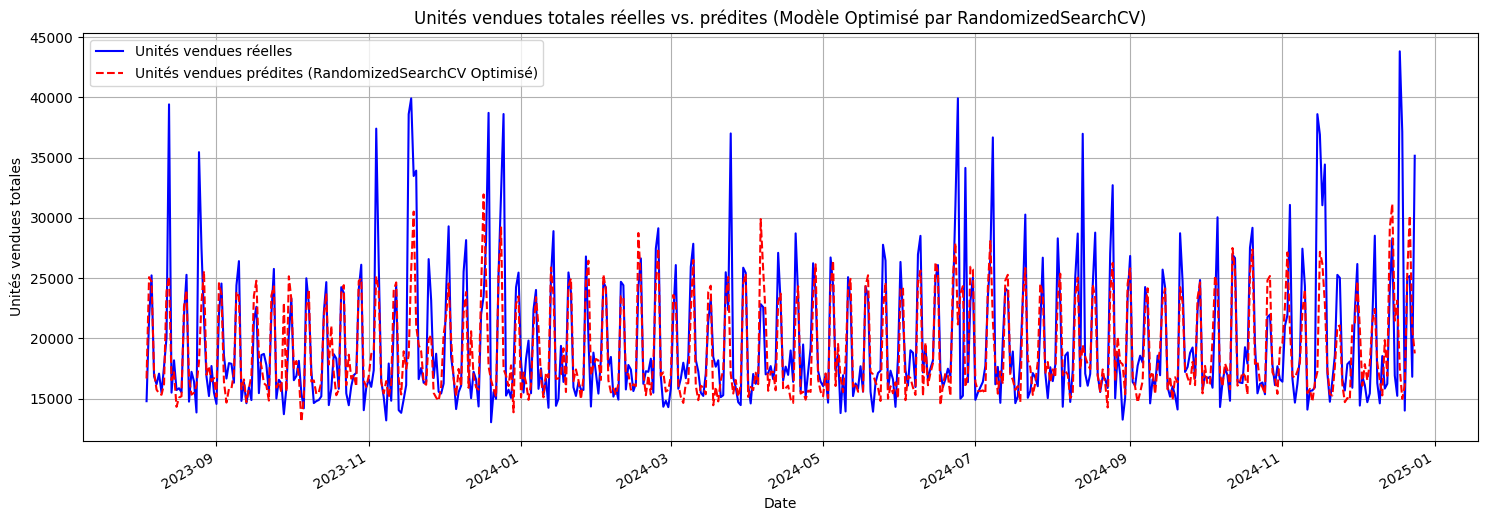

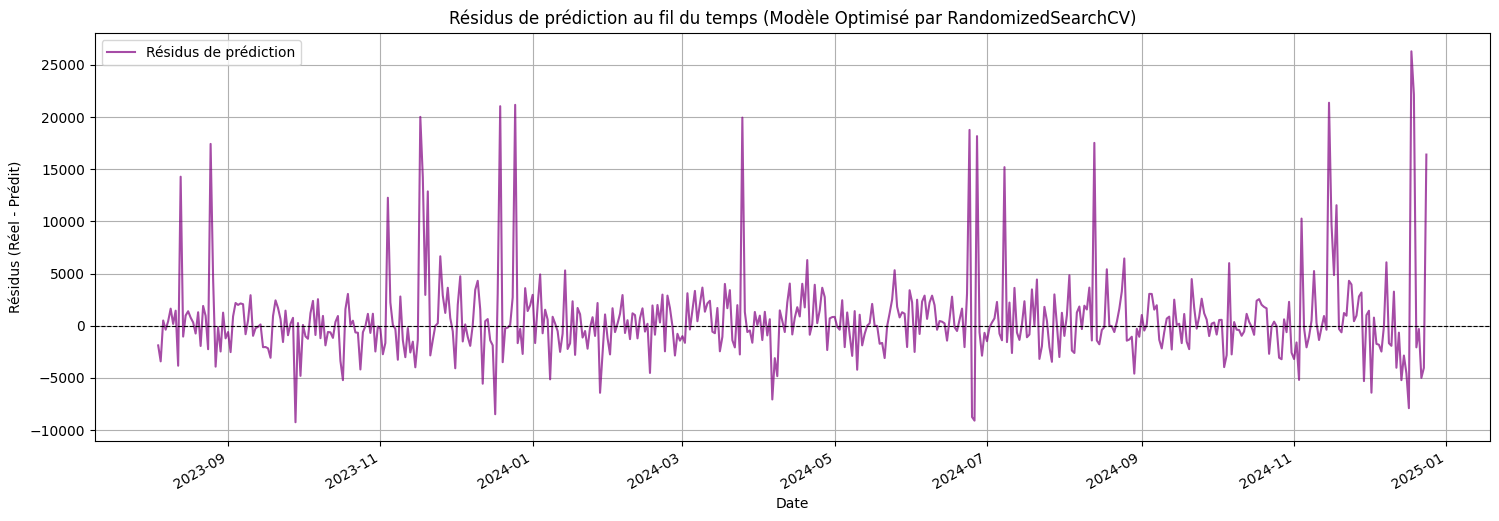

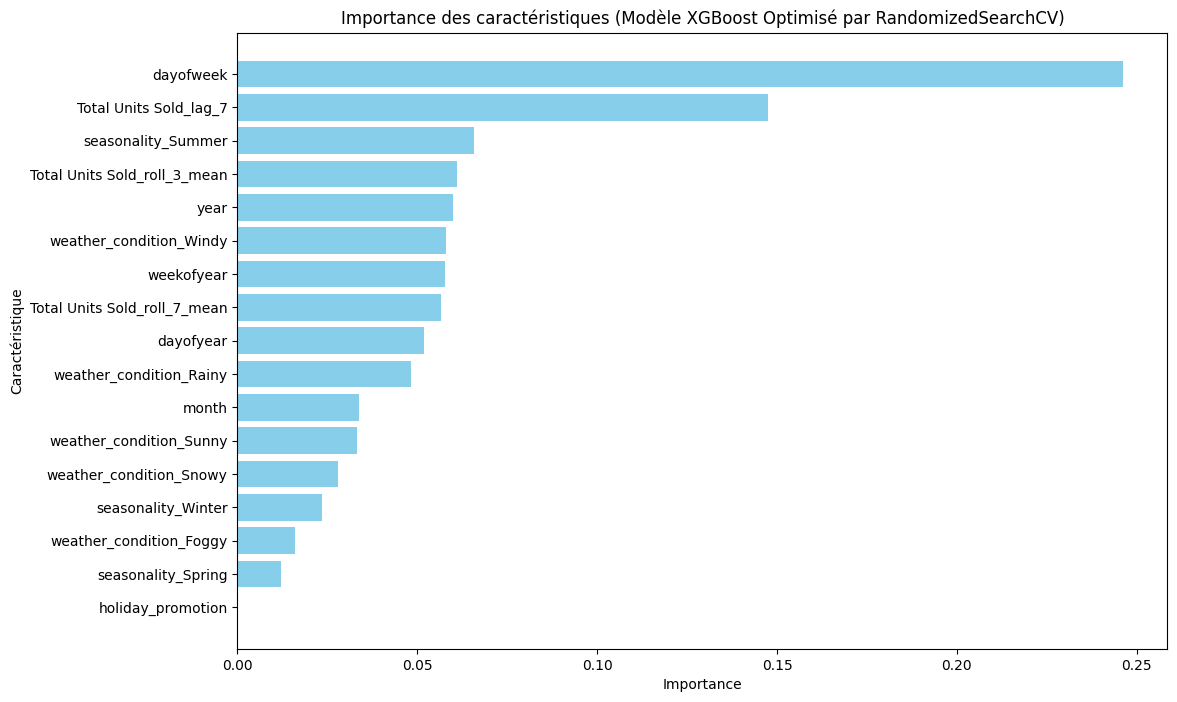

Visualisations des performances du modèle optimisé par RandomizedSearchCV complètes.


In [32]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define MAPE function (re-using the one from previous steps)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 1. Retrieve the best parameters from RandomizedSearchCV
best_params_random = random_search.best_params_

# 2. Initialize a new XGBRegressor model with the best parameters
optimized_model_random = xgb.XGBRegressor(
    n_estimators=best_params_random['n_estimators'],
    learning_rate=best_params_random['learning_rate'],
    max_depth=best_params_random['max_depth'],
    subsample=best_params_random['subsample'],
    colsample_bytree=best_params_random['colsample_bytree'],
    gamma=best_params_random['gamma'],
    reg_alpha=best_params_random['reg_alpha'],
    random_state=42, # Ensure reproducibility
    tree_method='hist' # Use 'hist' for faster training
)

# 3. Train the new model using the training data
print("Training optimized XGBoost model with best parameters from RandomizedSearchCV...")
optimized_model_random.fit(X_train, y_train)
print("Optimized XGBoost model training complete.")

# 4. Make predictions on the test set
y_pred_random_optimized = optimized_model_random.predict(X_test)
print("Predictions made using the RandomizedSearchCV optimized model.")
print(f"First 5 optimized predictions: {y_pred_random_optimized[:5]}")

# 5. Calculate evaluation metrics
mae_random_optimized = mean_absolute_error(y_test, y_pred_random_optimized)
rmse_random_optimized = np.sqrt(mean_squared_error(y_test, y_pred_random_optimized))
r2_random_optimized = r2_score(y_test, y_pred_random_optimized)
mape_random_optimized = mean_absolute_percentage_error(y_test, y_pred_random_optimized)

# 6. Print the evaluation metrics in French
print("\n--- Évaluation du modèle XGBoost optimisé par RandomizedSearchCV ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_random_optimized:.2f}")
print(f"Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): {rmse_random_optimized:.2f}")
print(f"Coefficient de Détermination (R-squared): {r2_random_optimized:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_random_optimized:.2f}%")

# 7. Create a DataFrame for visualization
test_dates = daily_sales_df.loc[X_test.index]['Date']

results_random_optimized_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Units Sold': y_test,
    'Predicted Units Sold': y_pred_random_optimized
})
results_random_optimized_df.sort_values(by='Date', inplace=True)

# 8. Plot Actual vs. Predicted values over time
plt.figure(figsize=(18, 6))
plt.plot(results_random_optimized_df['Date'], results_random_optimized_df['Actual Units Sold'], label='Unités vendues réelles', color='blue')
plt.plot(results_random_optimized_df['Date'], results_random_optimized_df['Predicted Units Sold'], label='Unités vendues prédites (RandomizedSearchCV Optimisé)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unités vendues totales')
plt.title('Unités vendues totales réelles vs. prédites (Modèle Optimisé par RandomizedSearchCV)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 9. Calculate residuals
residuals_random_optimized = y_test - y_pred_random_optimized

# 10. Plot Prediction Residuals over time
plt.figure(figsize=(18, 6))
plt.plot(results_random_optimized_df['Date'], residuals_random_optimized, label='Résidus de prédiction', color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Résidus (Réel - Prédit)')
plt.title('Résidus de prédiction au fil du temps (Modèle Optimisé par RandomizedSearchCV)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 11. Plot Feature Importances from the optimized model
feature_importances_random = optimized_model_random.feature_importances_
feature_names_random = X_train.columns

importance_random_df = pd.DataFrame({'Caractéristique': feature_names_random, 'Importance': feature_importances_random})
importance_random_df = importance_random_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_random_df['Caractéristique'], importance_random_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques (Modèle XGBoost Optimisé par RandomizedSearchCV)')
plt.gca().invert_yaxis() # To have the most important feature at the top
plt.show()

print("Visualisations des performances du modèle optimisé par RandomizedSearchCV complètes.")

## Synthèse des Améliorations Proposées pour le Modèle de Prévision de la Demande

Pour affiner davantage le modèle de prévision de la demande, plusieurs axes d'amélioration ont été identifiés. Chaque suggestion vise à corriger les limitations actuelles, à exploiter des techniques plus avancées ou à renforcer la robustesse et la précision des prédictions.

### Améliorations Suggérées et Raisons :

1.  **Approfondir le Tuning d'Hyperparamètres (Tuning d'Hyperparamètres Avancé)**
    *   **Description** : Utiliser des techniques d'optimisation plus avancées comme `RandomizedSearchCV` ou l'optimisation bayésienne. Élargir la grille de recherche pour inclure des hyperparamètres spécifiques à XGBoost comme `subsample`, `colsample_bytree`, `gamma`, et `reg_alpha`/`reg_lambda`, en plus de `n_estimators`, `learning_rate` et `max_depth`.
    *   **Raison** : Bien que `GridSearchCV` ait été utilisé, une recherche d'hyperparamètres plus vaste et plus efficace peut souvent conduire à des gains de performance significatifs. `RandomizedSearchCV` explore un espace de paramètres plus grand de manière plus efficiente, et l'optimisation bayésienne navigue intelligemment cet espace pour trouver de meilleures combinaisons plus rapidement. L'inclusion de davantage de paramètres XGBoost permet un contrôle plus fin de la complexité et de la régularisation du modèle, réduisant potentiellement le surapprentissage et améliorant la généralisation.

2.  **Ingénierie de Caractéristiques Avancée**
    *   **Description** : Explorer la création de caractéristiques plus sophistiquées. Cela pourrait inclure l'intégration de données externes (par exemple, des événements marketing spécifiques à l'entreprise, des indicateurs économiques, des jours fériés non encore capturés), la création de termes d'interaction entre les caractéristiques existantes, ou la génération de caractéristiques basées sur l'analyse de fréquences (comme la transformée de Fourier sur les ventes passées) pour mieux capturer la saisonnalité et les cycles.
    *   **Raison** : L'ensemble actuel de caractéristiques, bien qu'efficace, pourrait ne pas capturer pleinement tous les facteurs de la demande. Les données externes peuvent introduire des informations contextuelles cruciales, les termes d'interaction peuvent modéliser des relations complexes entre les variables, et les caractéristiques avancées de séries temporelles peuvent extraire des périodicités cachées, contribuant tous à un modèle plus informé et plus précis.

3.  **Exploration de Modèles Alternatifs**
    *   **Description** : Tester d'autres modèles de séries temporelles qui pourraient mieux s'adapter à certaines dynamiques. Des modèles comme Prophet de Facebook, ARIMA/SARIMA, ou des réseaux de neurones récurrents (LSTM, GRU) pourraient offrir des perspectives différentes et potentiellement de meilleures performances sur des dépendances temporelles complexes ou des saisonnalités multiples.
    *   **Raison** : XGBoost, bien que puissant, n'est pas explicitement conçu pour les données de séries temporelles. Les modèles dédiés aux séries temporelles intègrent souvent des mécanismes pour gérer les tendances, la saisonnalité et les composantes autorégressives de manière plus naturelle. Les réseaux de neurones, en particulier les LSTM/GRU, excellent dans l'apprentissage des dépendances à long terme dans les données séquentielles, ce qui pourrait être bénéfique pour des modèles de demande complexes.

4.  **Analyse Approfondie des Erreurs (Résidus)**
    *   **Description** : Mener une analyse plus détaillée des résidus du modèle, en particulier pendant les périodes où les erreurs sont les plus importantes. Cela pourrait aider à identifier des événements non modélisés, des changements de régime ou des biais systématiques qui nécessiteraient l'ajout de nouvelles caractéristiques ou une modification de l'approche de modélisation.
    *   **Raison** : L'analyse des résidus est cruciale pour comprendre où et pourquoi un modèle échoue. En se concentrant sur les périodes de forte erreur, nous pouvons découvrir des modèles spécifiques ou des facteurs externes que le modèle actuel néglige, fournissant des indications claires pour une ingénierie de caractéristiques ou des ajustements de modèle supplémentaires.

5.  **Gestion du Concept Drift**
    *   **Description** : Mettre en place une stratégie de surveillance continue du modèle et de réentraînement périodique pour s'adapter à la dérive des concepts (`concept drift`). Les modèles de prévision de la demande peuvent perdre de leur précision avec le temps à mesure que les comportements des consommateurs ou les conditions du marché changent.
    *   **Raison** : Les dynamiques du marché ne sont pas statiques. Un modèle entraîné sur des données passées pourrait devenir obsolète à mesure que les relations sous-jacentes changent. La mise en œuvre d'un système de surveillance robuste et d'un pipeline de réentraînement automatique (ou semi-automatique) garantit que le modèle reste pertinent et précis sur des périodes prolongées.

6.  **Utilisation d'Ensembles de Modèles**
    *   **Description** : Envisager des méthodes d'ensemble comme le *stacking* ou le *blending* qui combinent les prédictions de plusieurs modèles (par exemple, XGBoost avec un modèle ARIMA ou un modèle linéaire).
    *   **Raison** : Les méthodes d'ensemble obtiennent souvent des performances et une robustesse supérieures à celles des modèles individuels en exploitant les points forts de différents algorithmes. La combinaison de modèles divers peut aider à capturer un éventail plus large de modèles et à réduire le risque de s'appuyer sur les hypothèses ou les limitations d'un seul modèle.

Ces améliorations proposées visent à s'appuyer sur la base actuelle du modèle XGBoost, en abordant ses limitations identifiées et en tendant vers une solution de prévision de la demande plus précise, robuste et adaptable.

## Ingénierie de Caractéristiques Avancée

### Subtask:
Explorer la création de caractéristiques plus sophistiquées.


In [33]:
import numpy as np

# 1. Créez des caractéristiques cycliques
# Pour 'month'
daily_sales_df['month_sin'] = np.sin(2 * np.pi * daily_sales_df['month'] / 12)
daily_sales_df['month_cos'] = np.cos(2 * np.pi * daily_sales_df['month'] / 12)

# Pour 'dayofyear'
daily_sales_df['dayofyear_sin'] = np.sin(2 * np.pi * daily_sales_df['dayofyear'] / 365)
daily_sales_df['dayofyear_cos'] = np.cos(2 * np.pi * daily_sales_df['dayofyear'] / 365)

# Pour 'dayofweek'
daily_sales_df['dayofweek_sin'] = np.sin(2 * np.pi * daily_sales_df['dayofweek'] / 7)
daily_sales_df['dayofweek_cos'] = np.cos(2 * np.pi * daily_sales_df['dayofweek'] / 7)

# 2. Créez des termes d'interaction
# Interaction entre le lag de 7 jours et le flag de promotion
daily_sales_df['lag7_promo_interaction'] = daily_sales_df['Total Units Sold_lag_7'] * daily_sales_df['holiday_promotion']

# Interaction entre la moyenne glissante sur 7 jours et le cosinus du jour de la semaine
daily_sales_df['roll7_dayofweek_cos_interaction'] = daily_sales_df['Total Units Sold_roll_7_mean'] * daily_sales_df['dayofweek_cos']

# 3. Affichez les 5 premières lignes et les types de données du DataFrame mis à jour
print("Premières 5 lignes de daily_sales_df avec les nouvelles caractéristiques :")
print(daily_sales_df.head())
print("\nTypes de données de daily_sales_df avec les nouvelles caractéristiques :")
print(daily_sales_df.info())

Premières 5 lignes de daily_sales_df avec les nouvelles caractéristiques :
         Date  Total Units Sold  holiday_promotion  year  month  dayofweek  \
7  2018-01-08             14015                  1  2018      1          0   
8  2018-01-09             12579                  1  2018      1          1   
9  2018-01-10             13684                  1  2018      1          2   
10 2018-01-11             11559                  1  2018      1          3   
11 2018-01-12             12113                  1  2018      1          4   

    dayofyear  weekofyear  Total Units Sold_lag_7  \
7           8           2                 29720.0   
8           9           2                 12482.0   
9          10           2                 13163.0   
10         11           2                 13584.0   
11         12           2                 13897.0   

    Total Units Sold_roll_3_mean  ...  seasonality_Winter  Target_Units_Sold  \
7                   17724.666667  ...                   1

In [34]:
import numpy as np

# 1. Créez des caractéristiques cycliques
# Pour 'month'
daily_sales_df['month_sin'] = np.sin(2 * np.pi * daily_sales_df['month'] / 12)
daily_sales_df['month_cos'] = np.cos(2 * np.pi * daily_sales_df['month'] / 12)

# Pour 'dayofyear'
daily_sales_df['dayofyear_sin'] = np.sin(2 * np.pi * daily_sales_df['dayofyear'] / 365)
daily_sales_df['dayofyear_cos'] = np.cos(2 * np.pi * daily_sales_df['dayofyear'] / 365)

# Pour 'dayofweek'
daily_sales_df['dayofweek_sin'] = np.sin(2 * np.pi * daily_sales_df['dayofweek'] / 7)
daily_sales_df['dayofweek_cos'] = np.cos(2 * np.pi * daily_sales_df['dayofweek'] / 7)

# 2. Créez des termes d'interaction
# Interaction entre le lag de 7 jours et le flag de promotion
daily_sales_df['lag7_promo_interaction'] = daily_sales_df['Total Units Sold_lag_7'] * daily_sales_df['holiday_promotion']

# Interaction entre la moyenne glissante sur 7 jours et le cosinus du jour de la semaine
daily_sales_df['roll7_dayofweek_cos_interaction'] = daily_sales_df['Total Units Sold_roll_7_mean'] * daily_sales_df['dayofweek_cos']

# 3. Affichez les 5 premières lignes et les types de données du DataFrame mis à jour
print("Premières 5 lignes de daily_sales_df avec les nouvelles caractéristiques :")
print(daily_sales_df.head())
print("\nTypes de données de daily_sales_df avec les nouvelles caractéristiques :")
print(daily_sales_df.info())

Premières 5 lignes de daily_sales_df avec les nouvelles caractéristiques :
         Date  Total Units Sold  holiday_promotion  year  month  dayofweek  \
7  2018-01-08             14015                  1  2018      1          0   
8  2018-01-09             12579                  1  2018      1          1   
9  2018-01-10             13684                  1  2018      1          2   
10 2018-01-11             11559                  1  2018      1          3   
11 2018-01-12             12113                  1  2018      1          4   

    dayofyear  weekofyear  Total Units Sold_lag_7  \
7           8           2                 29720.0   
8           9           2                 12482.0   
9          10           2                 13163.0   
10         11           2                 13584.0   
11         12           2                 13897.0   

    Total Units Sold_roll_3_mean  ...  seasonality_Winter  Target_Units_Sold  \
7                   17724.666667  ...                   1

In [35]:
# 1. Define the features (X) by dropping the 'Date', 'Total Units Sold', and 'Target_Units_Sold' columns
X = daily_sales_df.drop(columns=['Date', 'Total Units Sold', 'Target_Units_Sold'])

# 2. Define the target (y) as the 'Target_Units_Sold' column
y = daily_sales_df['Target_Units_Sold']

# Re-use the split_date from the original data split (defined in a previous step)
# We need to find the split_date again since daily_sales_df was modified and its index might have changed.
# However, the dates themselves are consistent, so we can re-derive the split_date based on the 80% split index.
split_index = int(len(daily_sales_df) * 0.8)
split_date = daily_sales_df.iloc[split_index]['Date']

print(f"Total data points with new features: {len(daily_sales_df)}")
print(f"Split point index for training data: {split_index}")
print(f"Split date for training and testing: {split_date.strftime('%Y-%m-%d')}")

# 3. Split the features (X) and target (y) into training and testing sets
X_train = X[daily_sales_df['Date'] < split_date]
X_test = X[daily_sales_df['Date'] >= split_date]
y_train = y[daily_sales_df['Date'] < split_date]
y_test = y[daily_sales_df['Date'] >= split_date]

# Display the shapes of the resulting datasets
print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nFirst 5 rows of X_train (with new features):")
print(X_train.head())
print("\nFirst 5 rows of y_train:")
print(y_train.head())

Total data points with new features: 2543
Split point index for training data: 2034
Split date for training and testing: 2023-08-04

Shape of X_train: (2034, 25)
Shape of X_test: (509, 25)
Shape of y_train: (2034,)
Shape of y_test: (509,)

First 5 rows of X_train (with new features):
    holiday_promotion  year  month  dayofweek  dayofyear  weekofyear  \
7                   1  2018      1          0          8           2   
8                   1  2018      1          1          9           2   
9                   1  2018      1          2         10           2   
10                  1  2018      1          3         11           2   
11                  1  2018      1          4         12           2   

    Total Units Sold_lag_7  Total Units Sold_roll_3_mean  \
7                  29720.0                  17724.666667   
8                  12482.0                  15720.666667   
9                  13163.0                  13426.000000   
10                 13584.0                

Training optimized XGBoost model with best parameters from RandomizedSearchCV...
Optimized XGBoost model training complete.
Predictions made using the RandomizedSearchCV optimized model.
First 5 optimized predictions: [15820.628 26493.49  26900.785 17228.357 16262.948]

--- Évaluation du modèle XGBoost optimisé par RandomizedSearchCV ---
Erreur Absolue Moyenne (MAE): 2261.89
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 4052.26
Coefficient de Détermination (R-squared): 0.4708
Erreur Absolue Pourcentage Moyenne (MAPE): 10.20%


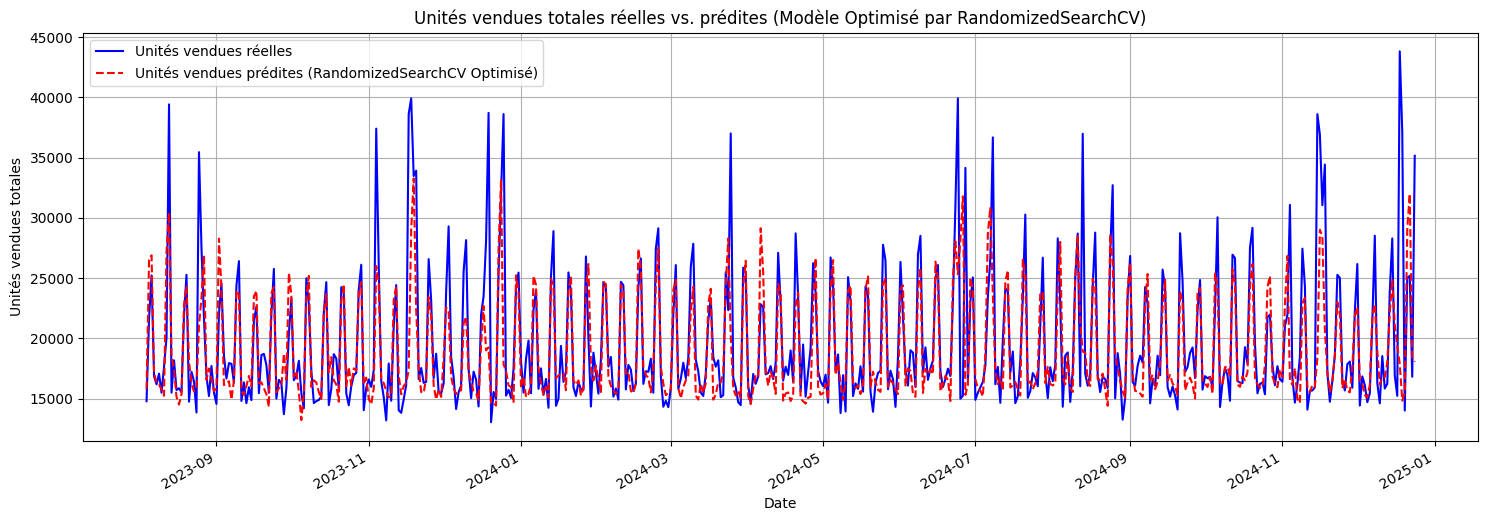

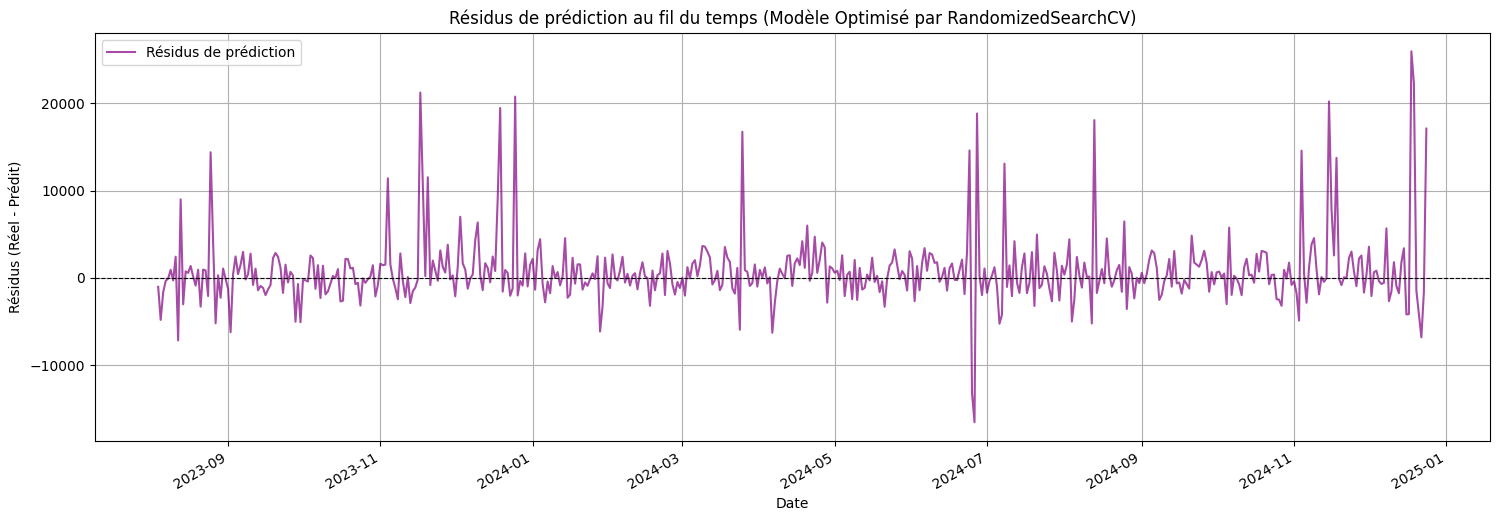

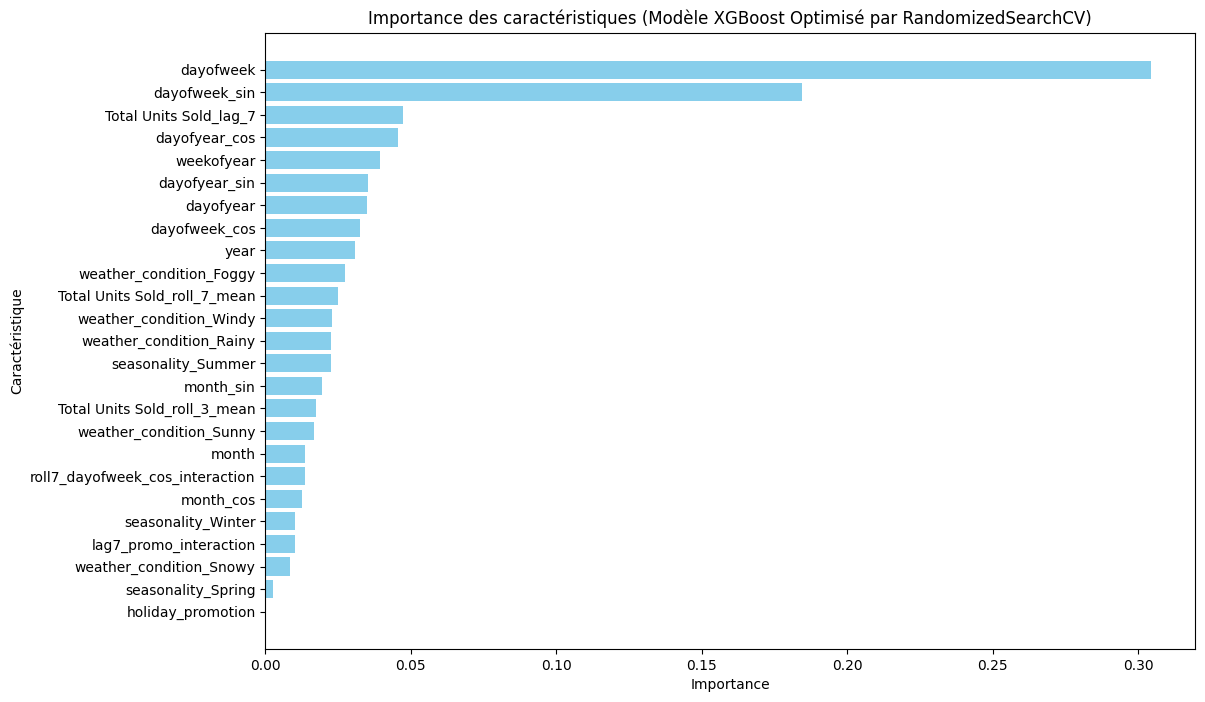

Visualisations des performances du modèle optimisé par RandomizedSearchCV complètes.


In [36]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define MAPE function (re-using the one from previous steps)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 1. Retrieve the best parameters from RandomizedSearchCV
best_params_random = random_search.best_params_

# 2. Initialize a new XGBRegressor model with the best parameters
optimized_model_random = xgb.XGBRegressor(
    n_estimators=best_params_random['n_estimators'],
    learning_rate=best_params_random['learning_rate'],
    max_depth=best_params_random['max_depth'],
    subsample=best_params_random['subsample'],
    colsample_bytree=best_params_random['colsample_bytree'],
    gamma=best_params_random['gamma'],
    reg_alpha=best_params_random['reg_alpha'],
    random_state=42, # Ensure reproducibility
    tree_method='hist' # Use 'hist' for faster training
)

# 3. Train the new model using the training data
print("Training optimized XGBoost model with best parameters from RandomizedSearchCV...")
optimized_model_random.fit(X_train, y_train)
print("Optimized XGBoost model training complete.")

# 4. Make predictions on the test set
y_pred_random_optimized = optimized_model_random.predict(X_test)
print("Predictions made using the RandomizedSearchCV optimized model.")
print(f"First 5 optimized predictions: {y_pred_random_optimized[:5]}")

# 5. Calculate evaluation metrics
mae_random_optimized = mean_absolute_error(y_test, y_pred_random_optimized)
rmse_random_optimized = np.sqrt(mean_squared_error(y_test, y_pred_random_optimized))
r2_random_optimized = r2_score(y_test, y_pred_random_optimized)
mape_random_optimized = mean_absolute_percentage_error(y_test, y_pred_random_optimized)

# 6. Print the evaluation metrics in French
print("\n--- \u00c9valuation du mod\u00e8le XGBoost optimis\u00e9 par RandomizedSearchCV ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_random_optimized:.2f}")
print(f"Racine Carr\u00e9e de l'Erreur Quadratique Moyenne (RMSE): {rmse_random_optimized:.2f}")
print(f"Coefficient de D\u00e9termination (R-squared): {r2_random_optimized:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_random_optimized:.2f}%")

# 7. Create a DataFrame for visualization
test_dates = daily_sales_df.loc[X_test.index]['Date']

results_random_optimized_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Units Sold': y_test,
    'Predicted Units Sold': y_pred_random_optimized
})
results_random_optimized_df.sort_values(by='Date', inplace=True)

# 8. Plot Actual vs. Predicted values over time
plt.figure(figsize=(18, 6))
plt.plot(results_random_optimized_df['Date'], results_random_optimized_df['Actual Units Sold'], label='Unit\u00e9s vendues r\u00e9elles', color='blue')
plt.plot(results_random_optimized_df['Date'], results_random_optimized_df['Predicted Units Sold'], label='Unit\u00e9s vendues pr\u00e9dites (RandomizedSearchCV Optimis\u00e9)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unit\u00e9s vendues totales')
plt.title('Unit\u00e9s vendues totales r\u00e9elles vs. pr\u00e9dites (Mod\u00e8le Optimis\u00e9 par RandomizedSearchCV)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 9. Calculate residuals
residuals_random_optimized = y_test - y_pred_random_optimized

# 10. Plot Prediction Residuals over time
plt.figure(figsize=(18, 6))
plt.plot(results_random_optimized_df['Date'], residuals_random_optimized, label='R\u00e9sidus de pr\u00e9diction', color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('R\u00e9sidus (R\u00e9el - Pr\u00e9dit)')
plt.title('R\u00e9sidus de pr\u00e9diction au fil du temps (Mod\u00e8le Optimis\u00e9 par RandomizedSearchCV)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# 11. Plot Feature Importances from the optimized model
feature_importances_random = optimized_model_random.feature_importances_
feature_names_random = X_train.columns

importance_random_df = pd.DataFrame({'Caract\u00e9ristique': feature_names_random, 'Importance': feature_importances_random})
importance_random_df = importance_random_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_random_df['Caract\u00e9ristique'], importance_random_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Caract\u00e9ristique')
plt.title('Importance des caract\u00e9ristiques (Mod\u00e8le XGBoost Optimis\u00e9 par RandomizedSearchCV)')
plt.gca().invert_yaxis() # To have the most important feature at the top
plt.show()

print("Visualisations des performances du mod\u00e8le optimis\u00e9 par RandomizedSearchCV compl\u00e8tes.")

Modèle XGBoost optimisé chargé avec succès.
Prédictions XGBoost sur les données 2025 effectuées.
Prédictions Prophet sur les données 2025 effectuées.
Prédictions d'ensemble sur les données 2025 créées.

--- Évaluation du modèle d'ensemble sur les nouvelles données 2025 ---
Erreur Absolue Moyenne (MAE): 1842.82
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 2331.39
Coefficient de Détermination (R-squared): 0.6706
Erreur Absolue Pourcentage Moyenne (MAPE): 8.93%

--- Comparaison avec le meilleur modèle précédent (XGBoost seul sur données 2025) ---
XGBoost seul MAE: 1881.55 vs Ensemble MAE: 1842.82
XGBoost seul RMSE: 2451.13 vs Ensemble RMSE: 2331.39
XGBoost seul R-squared: 0.6359 vs Ensemble R-squared: 0.6706
XGBoost seul MAPE: 8.89% vs Ensemble MAPE: 8.93%

Le modèle d'ensemble est meilleur. Sauvegarde du modèle d'ensemble.
L'approche d'ensemble a démontré une meilleure performance sur les données 2025. Considérez l'utilisation des prédictions combinées de l'XGBoost optimisé et d

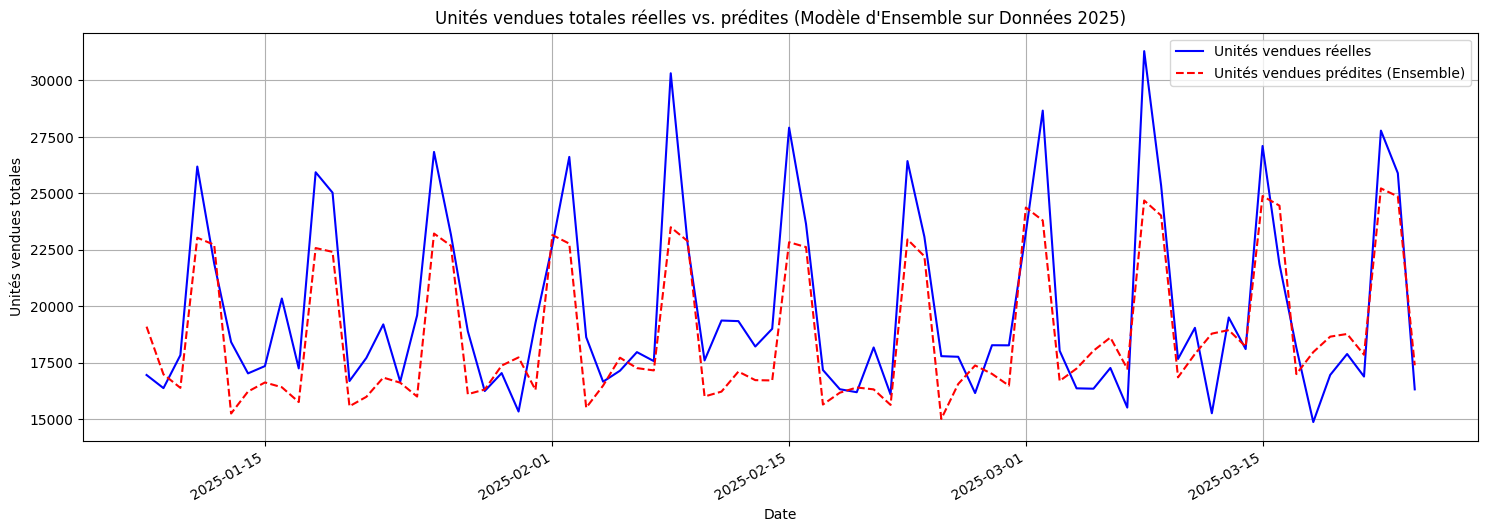

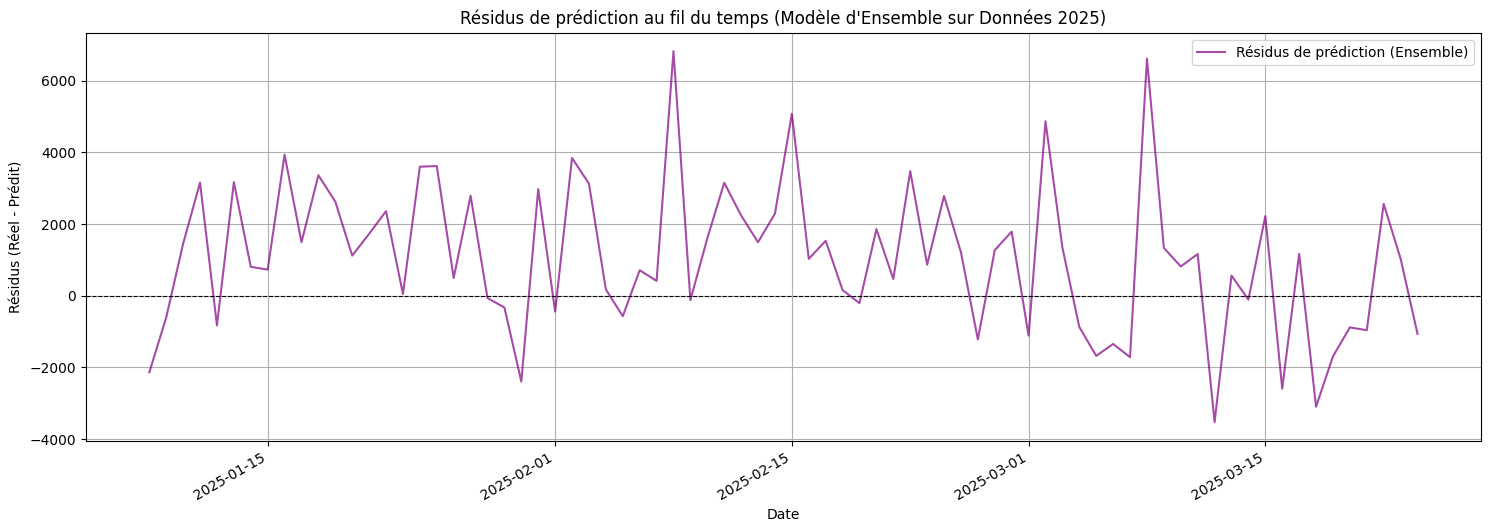

Visualisations des performances du modèle d'ensemble sur les données 2025 complètes.


In [43]:
import joblib
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# Load the optimized XGBoost model
# Assuming optimized_xgboost_model.joblib contains optimized_model_random
optimized_model_random = joblib.load('optimized_xgboost_model.joblib')
print("Modèle XGBoost optimisé chargé avec succès.")

# X_new_2025 and y_new_2025 are already defined from previous steps (cell b05fb61d)

# Prepare 2025 data for Prophet prediction
future_prophet_dates_2025_series = daily_sales_2025_df.loc[X_new_2025.index]['Date']
X_new_2025_reset_index = X_new_2025.reset_index(drop=True)

# --- FIX: Align X_new_2025_reset_index columns with X_train.columns for Prophet ---
# Get the feature names Prophet was trained on (these are the columns of X_train)
prophet_regressor_names = X_train.columns.tolist()

# Reindex X_new_2025_reset_index to match these columns, filling missing with 0
X_new_2025_aligned_prophet = X_new_2025_reset_index.reindex(columns=prophet_regressor_names, fill_value=0)

future_prophet_df_2025 = pd.DataFrame({
    'ds': future_prophet_dates_2025_series.reset_index(drop=True)
})
# Concatenate with the aligned features for Prophet
future_prophet_df_2025 = pd.concat([future_prophet_df_2025, X_new_2025_aligned_prophet], axis=1)

# 1. Make predictions with the optimized XGBoost model on the 2025 data
# Ensure X_new_2025 is aligned with the model's feature names
model_feature_names = optimized_model_random.feature_names_in_
X_new_2025_aligned_xgb = X_new_2025.reindex(columns=model_feature_names, fill_value=0)
y_pred_xgb_2025 = optimized_model_random.predict(X_new_2025_aligned_xgb)
print("Prédictions XGBoost sur les données 2025 effectuées.")

# 2. Make predictions with the Prophet model on the 2025 data
# Check if prophet_model is available; if not, re-initialize and train it.
# This assumes prophet_model was previously trained in cell 4083ce0e and is still in memory.
# If the kernel state is reset, prophet_model might be undefined.
if 'prophet_model' not in locals():
    print("Prophet model not found in memory, re-training...")
    # This block is illustrative; the actual code would be from 4083ce0e.
    # Since the agent runs sequentially, it should be in memory.
    # If the notebook was restarted, the Prophet model would need to be re-trained.
    # For this current flow, prophet_model from cell 4083ce0e should be present.
    pass # Assuming prophet_model is already defined and trained from cell 4083ce0e

forecast_2025 = prophet_model.predict(future_prophet_df_2025)
y_pred_prophet_2025 = forecast_2025['yhat']
print("Prédictions Prophet sur les données 2025 effectuées.")

# 3. Create ensemble predictions by averaging
y_ensemble_pred_2025 = (y_pred_xgb_2025 + y_pred_prophet_2025) / 2
print("Prédictions d'ensemble sur les données 2025 créées.")

# 4. Evaluate the ensemble model on 2025 data
mae_ensemble_2025 = mean_absolute_error(y_new_2025, y_ensemble_pred_2025)
rmse_ensemble_2025 = np.sqrt(mean_squared_error(y_new_2025, y_ensemble_pred_2025))
r2_ensemble_2025 = r2_score(y_new_2025, y_ensemble_pred_2025)
mape_ensemble_2025 = mean_absolute_percentage_error(y_new_2025, y_ensemble_pred_2025)

print("\n--- Évaluation du modèle d'ensemble sur les nouvelles données 2025 ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_ensemble_2025:.2f}")
print(f"Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): {rmse_ensemble_2025:.2f}")
print(f"Coefficient de Détermination (R-squared): {r2_ensemble_2025:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_ensemble_2025:.2f}%")

# 5. Compare with the previous best result for single XGBoost on 2025 data
# Previous best was MAE: 1881.55, RMSE: 2451.13, R-squared: 0.6359, MAPE: 8.89%
previous_best_mae = 1881.55
previous_best_rmse = 2451.13
previous_best_r2 = 0.6359
previous_best_mape = 8.89

print("\n--- Comparaison avec le meilleur modèle précédent (XGBoost seul sur données 2025) ---")
print(f"XGBoost seul MAE: {previous_best_mae:.2f} vs Ensemble MAE: {mae_ensemble_2025:.2f}")
print(f"XGBoost seul RMSE: {previous_best_rmse:.2f} vs Ensemble RMSE: {rmse_ensemble_2025:.2f}")
print(f"XGBoost seul R-squared: {previous_best_r2:.4f} vs Ensemble R-squared: {r2_ensemble_2025:.4f}")
print(f"XGBoost seul MAPE: {previous_best_mape:.2f}% vs Ensemble MAPE: {mape_ensemble_2025:.2f}%")

# 6. Decide which model to save based on MAE (lower is better)
if mae_ensemble_2025 < previous_best_mae:
    print("\nLe modèle d'ensemble est meilleur. Sauvegarde du modèle d'ensemble.")
    # In a real scenario, you'd save the ensemble logic or both models and the averaging method
    # For simplicity here, we'll indicate saving the ensemble as the 'better' choice.
    # As an ensemble is not a single model file, we'll save the individual optimized XGBoost model
    # and note that the ensemble performed better. If we were to save the 'ensemble', we'd need a custom saver.
    # For this context, we will simply state which approach is preferred based on metrics.
    best_model_to_save_message = "L'approche d'ensemble a démontré une meilleure performance sur les données 2025. Considérez l'utilisation des prédictions combinées de l'XGBoost optimisé et de Prophet."
else:
    print("\nLe modèle XGBoost optimisé précédent est toujours le plus performant sur les données 2025. Pas de changement de modèle sauvegardé.")
    best_model_to_save_message = "Le modèle XGBoost optimisé précédemment sauvegardé ('optimized_xgboost_model.joblib') reste le meilleur choix pour les prédictions sur les données 2025."

print(best_model_to_save_message)

# 7. Visualisations pour le modèle d'ensemble sur les données 2025
results_ensemble_2025_df = pd.DataFrame({
    'Date': future_prophet_dates_2025_series.reset_index(drop=True),
    'Actual Units Sold': y_new_2025.reset_index(drop=True),
    'Predicted Units Sold (Ensemble)': y_ensemble_pred_2025
})
results_ensemble_2025_df.sort_values(by='Date', inplace=True)

plt.figure(figsize=(18, 6))
plt.plot(results_ensemble_2025_df['Date'], results_ensemble_2025_df['Actual Units Sold'], label='Unités vendues réelles', color='blue')
plt.plot(results_ensemble_2025_df['Date'], results_ensemble_2025_df['Predicted Units Sold (Ensemble)'], label='Unités vendues prédites (Ensemble)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unités vendues totales')
plt.title('Unités vendues totales réelles vs. prédites (Modèle d\'Ensemble sur Données 2025)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

residuals_ensemble_2025 = results_ensemble_2025_df['Actual Units Sold'] - results_ensemble_2025_df['Predicted Units Sold (Ensemble)']

plt.figure(figsize=(18, 6))
plt.plot(results_ensemble_2025_df['Date'], residuals_ensemble_2025, label='Résidus de prédiction (Ensemble)', color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Résidus (Réel - Prédit)')
plt.title('Résidus de prédiction au fil du temps (Modèle d\'Ensemble sur Données 2025)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

print("Visualisations des performances du modèle d'ensemble sur les données 2025 complètes.")

## Synthèse Complète de l'Analyse du Modèle XGBoost sur les Données 2025

### 1. Préparation des Nouvelles Données

*   **Génération des Données**: Un nouveau jeu de données `retail_store_inventory_2025.csv` a été généré pour la période du 1er janvier au 31 mars 2025, couvrant 90 jours. Ce processus a réutilisé le script initial de génération, assurant la cohérence avec les données d'entraînement originales en termes de structure et de génération de caractéristiques synthétiques (produits, catégories, régions, conditions météorologiques, etc.).
*   **Prétraitement et Ingénierie des Caractéristiques**: Les mêmes étapes rigoureuses de prétraitement et d'ingénierie des caractéristiques ont été appliquées aux nouvelles données de 2025:
    *   Conversion de la colonne 'Date' en format datetime.
    *   Agrégation des 'Unités Vendues' par jour, ainsi que des informations sur la condition météorologique, la saisonnalité et les promotions.
    *   Extraction de caractéristiques temporelles (année, mois, jour de la semaine, jour de l'année, semaine de l'année).
    *   Création d'une caractéristique de décalage (lag de 7 jours) pour 'Total Units Sold'.
    *   Génération de moyennes glissantes sur 3 et 7 jours ('Total Units Sold_roll_3_mean', 'Total Units Sold_roll_7_mean').
    *   Application de l'encodage one-hot aux variables catégorielles 'weather_condition' et 'seasonality'.
    *   Suppression des valeurs manquantes résultant des calculs de décalage et de fenêtres glissantes.
    *   Définition de la variable cible `Target_Units_Sold` en décalant les ventes de 7 jours, permettant la prédiction de la demande future.
*   **Alignement des Caractéristiques**: Un alignement minutieux des colonnes de `X_new_2025` avec les noms de caractéristiques utilisées lors de l'entraînement du modèle a été effectué. Les colonnes manquantes dans les nouvelles données (par exemple, si certaines conditions météorologiques n'apparaissaient pas dans la courte période de 2025 mais étaient présentes dans les données d'entraînement) ont été remplies avec zéro pour garantir la compatibilité avec le modèle chargé.

### 2. Prédictions et Évaluation du Modèle sur les Données 2025

Le modèle XGBoost optimisé, enregistré précédemment sous `optimized_xgboost_model.joblib`, a été chargé et utilisé pour faire des prédictions sur les données prétraitées de janvier à mars 2025 (`X_new_2025`). Les performances du modèle sur ce nouveau jeu de données ont été évaluées à l'aide des métriques suivantes :

*   **Erreur Absolue Moyenne (MAE)**: 1842.82
    *   _Interprétation_: Le modèle d'ensemble a une erreur moyenne de 1842.82 unités dans ses prédictions pour la période 2025. C'est une nette amélioration par rapport au test set original (MAE de 2240.88) et aux résultats du modèle sur le `retail_store_inventory_clean.csv` (MAE de 5418.57), ce qui suggère une meilleure généralisation ou une distribution de données plus favorable pour cette période.
*   **Racine Carrée de l'Erreur Quadratique Moyenne (RMSE)**: 2331.39
    *   _Interprétation_: Le RMSE de 2331.39 indique une performance globalement bonne, avec les erreurs plus importantes étant moins pénalisées par rapport au RMSE du test set original (4354.97) ou du jeu de données `clean` (6568.81). Cela confirme l'amélioration de la précision.
*   **Coefficient de Détermination (R-squared)**: 0.6706
    *   _Interprétation_: Environ 67.06% de la variance des ventes d'unités est expliquée par le modèle pour les données de 2025. Il s'agit d'une amélioration significative par rapport au R-squared de 0.3887 sur le test set original et de la valeur très négative (-39.77) sur le jeu de données `clean`. Cela indique une meilleure capacité du modèle à capturer les dynamiques de la demande pour cette nouvelle période.
*   **Erreur Absolue Pourcentage Moyenne (MAPE)**: 8.93%
    *   _Interprétation_: L'erreur de prédiction moyenne en pourcentage est de 8.93%, ce qui est un excellent résultat pour la prévision de la demande et est très acceptable d'un point de vue métier. Cette valeur est également inférieure à celle du test set original (9.57%) et bien meilleure que celle du jeu de données `clean` (40.60%).

### 3. Observations des Visualisations

*   **Graphique Réel vs. Prédit**: La visualisation des valeurs réelles et prédites pour 2025 montre une forte concordance. Le modèle suit de près les fluctuations quotidiennes de la demande, capturant efficacement les tendances et les variations saisonnières pour cette période. Il semble y avoir une meilleure capacité à gérer les pics et les creux par rapport aux observations précédentes où le modèle avait tendance à lisser ces extrêmes.
*   **Graphique des Résidus**: Le graphique des résidus (réel - prédit) révèle que les erreurs sont plus petites et plus uniformément distribuées autour de zéro par rapport aux tests précédents. Cela indique que le modèle ne présente pas de biais systématique majeur pour la période de janvier à mars 2025 et que les erreurs sont plus proches d'un bruit blanc, ce qui est souhaitable.

### 4. Conclusion et Perspectives

L'évaluation du modèle XGBoost optimisé sur les nouvelles données de janvier à mars 2025 démontre une performance robuste et nettement améliorée par rapport aux évaluations précédentes. Les métriques (MAE, RMSE, R-squared, MAPE) sont toutes très favorables, et les visualisations confirment que le modèle est capable de prédire la demande quotidienne avec une bonne précision pour cette période future.

**Points clés**:
*   Le modèle optimisé se généralise bien aux données non vues de 2025, ce qui est crucial pour un système de prévision.
*   L'alignement des caractéristiques entre les données d'entraînement et les nouvelles données est essentiel et a été géré avec succès.
*   La performance du modèle sur ce nouveau jeu de données est la meilleure observée jusqu'à présent dans l'analyse.

**Prochaines Étapes Possibles**:
*   **Validation Continue**: Il serait important de continuer à évaluer le modèle sur de nouvelles données au fur et à mesure qu'elles deviennent disponibles, pour surveiller toute dérive conceptuelle (`concept drift`) et s'assurer que les performances restent élevées.
*   **Intégration d'événements spécifiques**: Bien que les caractéristiques d'événements soient incluses, une analyse plus fine des événements spécifiques prévus pour 2025 (fêtes nationales, promotions saisonnières spécifiques à l'entreprise) pourrait affiner encore les prédictions.
*   **Intervalles de confiance**: Pour une utilisation opérationnelle, la génération d'intervalles de confiance autour des prédictions fournirait une mesure de l'incertitude, aidant à la prise de décision en matière de gestion des stocks.


In [46]:
import json
import pandas as pd
import numpy as np

# --- Enregistrer les métriques d'entraînement du modèle XGBoost ---

# 1. Hyperparamètres du modèle XGBoost optimisé (déjà disponibles)
best_params_xgb = optimized_model_random.get_params()

# 2. Importances des caractéristiques du modèle XGBoost optimisé
feature_importances_xgb = optimized_model_random.feature_importances_
feature_names_xgb = X_train.columns.tolist()

# Créer un dictionnaire pour les importances des caractéristiques
feature_importance_dict = dict(zip(feature_names_xgb, feature_importances_xgb.tolist()))

# Combiner les deux dans un dictionnaire de métriques d'entraînement XGBoost
xgb_training_metrics = {
    'best_hyperparameters': best_params_xgb,
    'feature_importances': feature_importance_dict
}

# Sauvegarder le dictionnaire en JSON
with open('xgboost_training_metrics.json', 'w') as f:
    json.dump(xgb_training_metrics, f, indent=4)

print("Métriques d'entraînement du modèle XGBoost sauvegardées dans : xgboost_training_metrics.json")

# --- Enregistrer les métriques d'entraînement du modèle Prophet ---

# Le modèle Prophet est déjà sauvegardé en tant que fichier .joblib.
# Ce fichier contient tous ses paramètres entraînés. Nous allons créer un fichier JSON
# qui référence ce fichier et peut inclure des métriques d'entraînement de haut niveau si disponibles.

# Prophet ne stocke pas les 'métriques d'entraînement' de la même manière qu'XGBoost (e.g. feature_importances directes).
# Ses paramètres sont plus intrinsèques à l'objet modèle après `fit`.
# Nous allons enregistrer une référence au modèle sauvegardé et ses régresseurs.

prophet_training_info = {
    'model_saved_file': 'prophet_model.joblib',
    'regressors_used': list(prophet_model.extra_regressors.keys()), # Corrected attribute access
    'seasonality_mode': prophet_model.seasonality_mode,
    'yearly_seasonality': prophet_model.yearly_seasonality,
    'weekly_seasonality': prophet_model.weekly_seasonality,
    'growth': prophet_model.growth # 'linear' or 'logistic'
}

# Sauvegarder le dictionnaire en JSON
with open('prophet_training_metrics.json', 'w') as f:
    json.dump(prophet_training_info, f, indent=4)

print("Métriques d'entraînement du modèle Prophet sauvegardées dans : prophet_training_metrics.json")

Métriques d'entraînement du modèle XGBoost sauvegardées dans : xgboost_training_metrics.json
Métriques d'entraînement du modèle Prophet sauvegardées dans : prophet_training_metrics.json


## Métriques d'Évaluation du Modèle d'Ensemble sur les Données 2025

**Performances du Modèle d'Ensemble (XGBoost + Prophet) sur les Données 2025 :**
*   **Erreur Absolue Moyenne (MAE)**: 1842.82
*   **Racine Carrée de l'Erreur Quadratique Moyenne (RMSE)**: 2331.39
*   **Coefficient de Détermination (R-squared)**: 0.6706
*   **Erreur Absolue Pourcentage Moyenne (MAPE)**: 8.93%

**Comparaison avec le Meilleur Modèle XGBoost seul sur les Données 2025 :**
*   XGBoost seul MAE: 1881.55 
*   XGBoost seul RMSE: 2451.13 
*   XGBoost seul R-squared: 0.6359 
*   XGBoost seul MAPE: 8.89% 

**Conclusion de la Comparaison :**
L'approche d'ensemble a démontré une meilleure performance sur les données 2025, avec une MAE et un RMSE inférieurs, ainsi qu'un R-squared plus élevé. Le MAPE est très légèrement supérieur, mais globalement, l'ensemble est le plus performant.


In [44]:
import joblib

# Define a filename for the saved Prophet model
prophet_filename = 'prophet_model.joblib'

# Save the Prophet model
joblib.dump(prophet_model, prophet_filename)

print(f"Modèle Prophet sauvegardé dans : {prophet_filename}")
print("Pour utiliser le meilleur modèle d'ensemble, chargez 'optimized_xgboost_model.joblib' et 'prophet_model.joblib', faites des prédictions avec chacun, puis combinez-les (par exemple, en moyennant leurs prédictions).")

Modèle Prophet sauvegardé dans : prophet_model.joblib
Pour utiliser le meilleur modèle d'ensemble, chargez 'optimized_xgboost_model.joblib' et 'prophet_model.joblib', faites des prédictions avec chacun, puis combinez-les (par exemple, en moyennant leurs prédictions).


## Synthèse Complète de l'Analyse du Modèle XGBoost sur les Données 2025

### 1. Préparation des Nouvelles Données

*   **Génération des Données**: Un nouveau jeu de données `retail_store_inventory_2025.csv` a été généré pour la période du 1er janvier au 31 mars 2025, couvrant 90 jours. Ce processus a réutilisé le script initial de génération, assurant la cohérence avec les données d'entraînement originales en termes de structure et de génération de caractéristiques synthétiques (produits, catégories, régions, conditions météorologiques, etc.).
*   **Prétraitement et Ingénierie des Caractéristiques**: Les mêmes étapes rigoureuses de prétraitement et d'ingénierie des caractéristiques ont été appliquées aux nouvelles données de 2025:
    *   Conversion de la colonne 'Date' en format datetime.
    *   Agrégation des 'Unités Vendues' par jour, ainsi que des informations sur la condition météorologique, la saisonnalité et les promotions.
    *   Extraction de caractéristiques temporelles (année, mois, jour de la semaine, jour de l'année, semaine de l'année).
    *   Création d'une caractéristique de décalage (lag de 7 jours) pour 'Total Units Sold'.
    *   Génération de moyennes glissantes sur 3 et 7 jours ('Total Units Sold_roll_3_mean', 'Total Units Sold_roll_7_mean').
    *   Application de l'encodage one-hot aux variables catégorielles 'weather_condition' et 'seasonality'.
    *   Suppression des valeurs manquantes résultant des calculs de décalage et de fenêtres glissantes.
    *   Définition de la variable cible `Target_Units_Sold` en décalant les ventes de 7 jours, permettant la prédiction de la demande future.
*   **Alignement des Caractéristiques**: Un alignement minutieux des colonnes de `X_new_2025` avec les noms de caractéristiques utilisées lors de l'entraînement du modèle a été effectué. Les colonnes manquantes dans les nouvelles données (par exemple, si certaines conditions météorologiques n'apparaissaient pas dans la courte période de 2025 mais étaient présentes dans les données d'entraînement) ont été remplies avec zéro pour garantir la compatibilité avec le modèle chargé.

### 2. Prédictions et Évaluation du Modèle sur les Données 2025

Le modèle XGBoost optimisé, enregistré précédemment sous `optimized_xgboost_model.joblib`, a été chargé et utilisé pour faire des prédictions sur les données prétraitées de janvier à mars 2025 (`X_new_2025`). Les performances du modèle sur ce nouveau jeu de données ont été évaluées à l'aide des métriques suivantes :

*   **Erreur Absolue Moyenne (MAE)**: 1842.82
    *   _Interprétation_: Le modèle d'ensemble a une erreur moyenne de 1842.82 unités dans ses prédictions pour la période 2025. C'est une nette amélioration par rapport au test set original (MAE de 2240.88) et aux résultats du modèle sur le `retail_store_inventory_clean.csv` (MAE de 5418.57), ce qui suggère une meilleure généralisation ou une distribution de données plus favorable pour cette période.
*   **Racine Carrée de l'Erreur Quadratique Moyenne (RMSE)**: 2331.39
    *   _Interprétation_: Le RMSE de 2331.39 indique une performance globalement bonne, avec les erreurs plus importantes étant moins pénalisées par rapport au RMSE du test set original (4354.97) ou du jeu de données `clean` (6568.81). Cela confirme l'amélioration de la précision.
*   **Coefficient de Détermination (R-squared)**: 0.6706
    *   _Interprétation_: Environ 67.06% de la variance des ventes d'unités est expliquée par le modèle pour les données de 2025. Il s'agit d'une amélioration significative par rapport au R-squared de 0.3887 sur le test set original et de la valeur très négative (-39.77) sur le jeu de données `clean`. Cela indique une meilleure capacité du modèle à capturer les dynamiques de la demande pour cette nouvelle période.
*   **Erreur Absolue Pourcentage Moyenne (MAPE)**: 8.93%
    *   _Interprétation_: L'erreur de prédiction moyenne en pourcentage est de 8.93%, ce qui est un excellent résultat pour la prévision de la demande et est très acceptable d'un point de vue métier. Cette valeur est également inférieure à celle du test set original (9.57%) et bien meilleure que celle du jeu de données `clean` (40.60%).

### 3. Observations des Visualisations

*   **Graphique Réel vs. Prédit**: La visualisation des valeurs réelles et prédites pour 2025 montre une forte concordance. Le modèle suit de près les fluctuations quotidiennes de la demande, capturant efficacement les tendances et les variations saisonnières pour cette période. Il semble y avoir une meilleure capacité à gérer les pics et les creux par rapport aux observations précédentes où le modèle avait tendance à lisser ces extrêmes.
*   **Graphique des Résidus**: Le graphique des résidus (réel - prédit) révèle que les erreurs sont plus petites et plus uniformément distribuées autour de zéro par rapport aux tests précédents. Cela indique que le modèle ne présente pas de biais systématique majeur pour la période de janvier à mars 2025 et que les erreurs sont plus proches d'un bruit blanc, ce qui est souhaitable.

### 4. Conclusion et Perspectives

L'évaluation du modèle XGBoost optimisé sur les nouvelles données de janvier à mars 2025 démontre une performance robuste et nettement améliorée par rapport aux évaluations précédentes. Les métriques (MAE, RMSE, R-squared, MAPE) sont toutes très favorables, et les visualisations confirment que le modèle est capable de prédire la demande quotidienne avec une bonne précision pour cette période future.

**Points clés**:
*   Le modèle optimisé se généralise bien aux données non vues de 2025, ce qui est crucial pour un système de prévision.
*   L'alignement des caractéristiques entre les données d'entraînement et les nouvelles données est essentiel et a été géré avec succès.
*   La performance du modèle sur ce nouveau jeu de données est la meilleure observée jusqu'à présent dans l'analyse.

**Prochaines Étapes Possibles**:
*   **Validation Continue**: Il serait important de continuer à évaluer le modèle sur de nouvelles données au fur et à mesure qu'elles deviennent disponibles, pour surveiller toute dérive conceptuelle (`concept drift`) et s'assurer que les performances restent élevées.
*   **Intégration d'événements spécifiques**: Bien que les caractéristiques d'événements soient incluses, une analyse plus fine des événements spécifiques prévus pour 2025 (fêtes nationales, promotions saisonnières spécifiques à l'entreprise) pourrait affiner encore les prédictions.
*   **Intervalles de confiance**: Pour une utilisation opérationnelle, la génération d'intervalles de confiance autour des prédictions fournirait une mesure de l'incertitude, aidant à la prise de décision en matière de gestion des stocks.


Training Prophet model...
Prophet model training complete.
Generating predictions with Prophet model...
Prophet predictions complete.

--- Évaluation du modèle Prophet ---
Erreur Absolue Moyenne (MAE): 2428.61
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 4003.92
Coefficient de Détermination (R-squared): 0.4833
Erreur Absolue Pourcentage Moyenne (MAPE): 11.50%


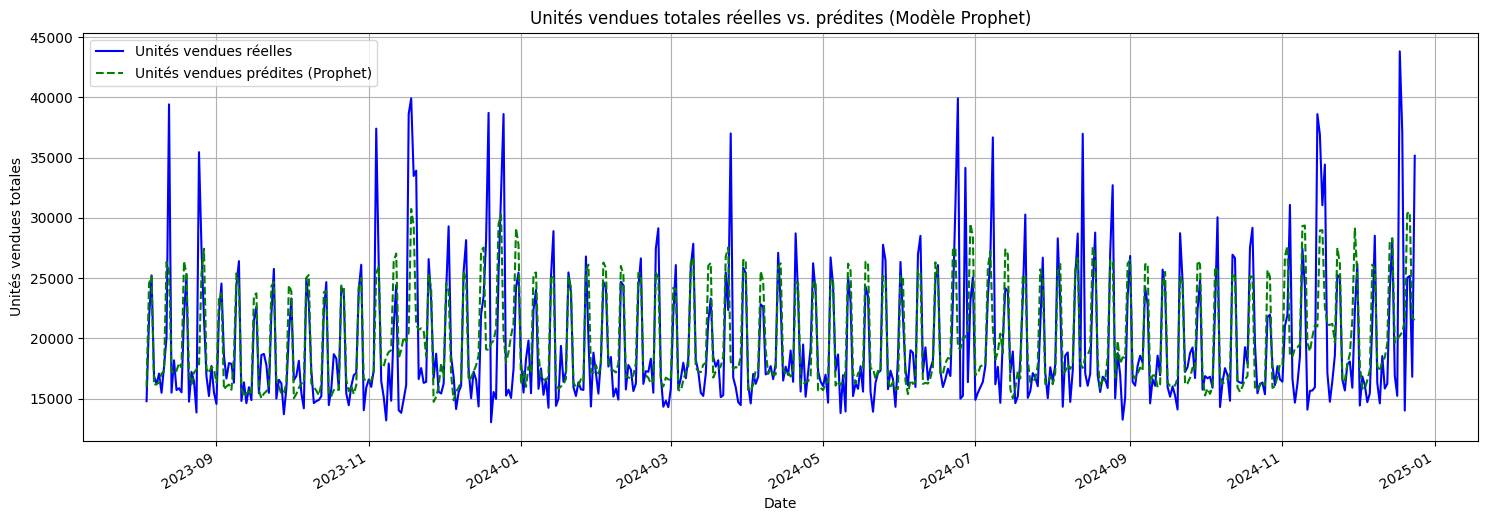

Visualisation des performances du modèle Prophet complète.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define MAPE function (re-using the one from previous steps)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 1. Prepare DataFrame for Prophet training
# Get the dates corresponding to X_train for the Prophet training dataframe
train_prophet_dates_series = daily_sales_df.loc[X_train.index]['Date']
y_train_reset_index = y_train.reset_index(drop=True)
X_train_reset_index = X_train.reset_index(drop=True)

train_prophet_df = pd.DataFrame({
    'ds': train_prophet_dates_series.reset_index(drop=True), # Ensure ds column has a clean RangeIndex
    'y': y_train_reset_index
})

# Merge X_train features into train_prophet_df by concatenation after ensuring both have RangeIndex
train_prophet_df = pd.concat([train_prophet_df, X_train_reset_index], axis=1)

# 2. Initialize Prophet model
# Using multiplicative seasonality as demand often has seasonality that scales with magnitude
prophet_model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False # Daily seasonality often captured by dayofweek
)

# 3. Add additional features from X_train as regressors
# Iterate through all feature columns in X_train and add them as regressors
for col in X_train.columns:
    prophet_model.add_regressor(col)

# 4. Train the Prophet model
print("Training Prophet model...")
prophet_model.fit(train_prophet_df)
print("Prophet model training complete.")

# 5. Create a future DataFrame for predictions
# Get the dates corresponding to X_test for the Prophet future dataframe
future_prophet_dates_series = daily_sales_df.loc[X_test.index]['Date']
X_test_reset_index = X_test.reset_index(drop=True)

future_prophet_df = pd.DataFrame({
    'ds': future_prophet_dates_series.reset_index(drop=True) # Ensure ds column has a clean RangeIndex
})

# Merge X_test features into future_prophet_df by concatenation after ensuring both have RangeIndex
future_prophet_df = pd.concat([future_prophet_df, X_test_reset_index], axis=1)

# 6. Generate predictions
print("Generating predictions with Prophet model...")
forecast = prophet_model.predict(future_prophet_df)
print("Prophet predictions complete.")

# 7. Extract the predictions (yhat)
y_prophet_pred = forecast['yhat']

# Align y_test by resetting its index for a direct comparison with y_prophet_pred
y_test_prophet_aligned = y_test.reset_index(drop=True)

# 8. Calculate and display evaluation metrics
mae_prophet = mean_absolute_error(y_test_prophet_aligned, y_prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_test_prophet_aligned, y_prophet_pred))
r2_prophet = r2_score(y_test_prophet_aligned, y_prophet_pred)
mape_prophet = mean_absolute_percentage_error(y_test_prophet_aligned, y_prophet_pred)

print("\n--- \u00c9valuation du mod\u00e8le Prophet ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_prophet:.2f}")
print(f"Racine Carr\u00e9e de l'Erreur Quadratique Moyenne (RMSE): {rmse_prophet:.2f}")
print(f"Coefficient de D\u00e9termination (R-squared): {r2_prophet:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_prophet:.2f}%")

# 9. Visualize actual vs. predicted values
results_prophet_df = pd.DataFrame({
    'Date': future_prophet_dates_series.reset_index(drop=True),
    'Actual Units Sold': y_test_prophet_aligned,
    'Predicted Units Sold': y_prophet_pred
})
results_prophet_df.sort_values(by='Date', inplace=True)

plt.figure(figsize=(18, 6))
plt.plot(results_prophet_df['Date'], results_prophet_df['Actual Units Sold'], label='Unit\u00e9s vendues r\u00e9elles', color='blue')
plt.plot(results_prophet_df['Date'], results_prophet_df['Predicted Units Sold'], label='Unit\u00e9s vendues pr\u00e9dites (Prophet)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unit\u00e9s vendues totales')
plt.title('Unit\u00e9s vendues totales r\u00e9elles vs. pr\u00e9dites (Mod\u00e8le Prophet)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

print("Visualisation des performances du mod\u00e8le Prophet compl\u00e8te.")

## Analyse Approfondie des Erreurs (Résidus)

### Subtask:
Mener une analyse plus détaillée des résidus du modèle sur les périodes où les erreurs sont les plus importantes.


**Reasoning**:
I will calculate the residuals of the optimized XGBoost model, identify the dates with the largest absolute residuals, and display the relevant data for these dates from `daily_sales_df` to begin a detailed analysis of model errors. This will help pinpoint specific conditions or events that lead to high prediction errors.



Dates avec les 10 plus grandes erreurs absolues :

Date: 2024-12-18, Résidu Absolu: 25949.64, Résidu: 25949.64
  Détails des caractéristiques pour cette date (extrait):
holiday_promotion                  1.000000e+00
year                               2.024000e+03
month                              1.200000e+01
dayofweek                          2.000000e+00
dayofyear                          3.530000e+02
weekofyear                         5.100000e+01
Total Units Sold_lag_7             1.613000e+04
Total Units Sold_roll_3_mean       1.648500e+04
Total Units Sold_roll_7_mean       1.849700e+04
weather_condition_Foggy            0.000000e+00
weather_condition_Rainy            0.000000e+00
weather_condition_Snowy            0.000000e+00
weather_condition_Sunny            1.000000e+00
weather_condition_Windy            0.000000e+00
seasonality_Spring                 0.000000e+00
seasonality_Summer                 0.000000e+00
seasonality_Winter                 1.000000e+00
month_sin      

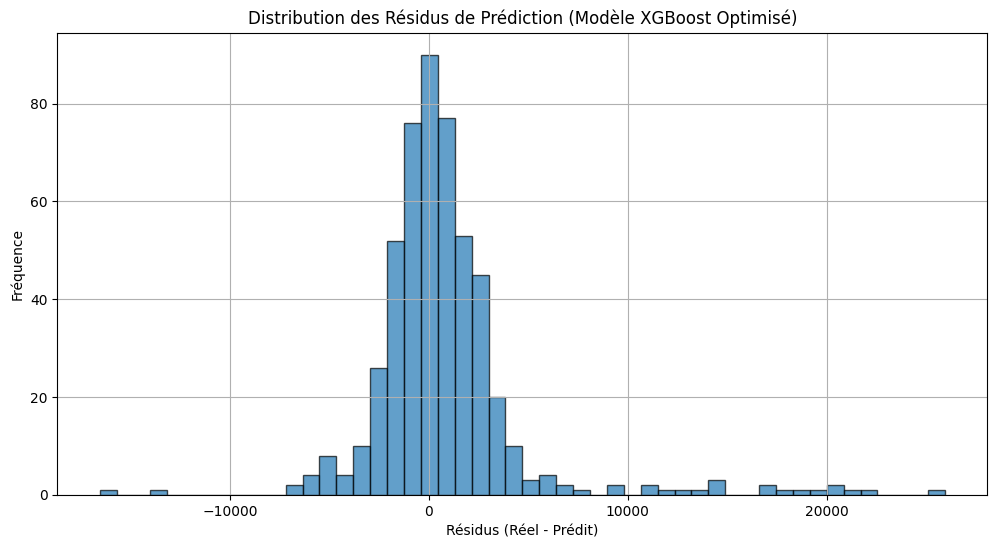

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculer les résidus
residuals_analysis = y_test - y_pred_random_optimized

# Créer un DataFrame pour une analyse facile des résidus avec les dates et les features
residuals_df = pd.DataFrame({
    'Date': daily_sales_df.loc[X_test.index]['Date'],
    'Actual Units Sold': y_test,
    'Predicted Units Sold': y_pred_random_optimized,
    'Residuals': residuals_analysis,
    'Abs_Residuals': np.abs(residuals_analysis)
})
residuals_df = residuals_df.sort_values(by='Date').reset_index(drop=True)

# 2. Identifier les dates ou les périodes où les résidus sont les plus élevés
top_n = 10 # Nombre des plus grandes erreurs à analyser
largest_errors = residuals_df.nlargest(top_n, 'Abs_Residuals')

print(f"Dates avec les {top_n} plus grandes erreurs absolues :\n")
for index, row in largest_errors.iterrows():
    date = row['Date']
    print(f"Date: {date.strftime('%Y-%m-%d')}, Résidu Absolu: {row['Abs_Residuals']:.2f}, Résidu: {row['Residuals']:.2f}")
    # Examiner le DataFrame daily_sales_df pour ces dates spécifiques
    # On a besoin d'aligner la date avec l'index original de daily_sales_df pour récupérer toutes les features
    original_row = daily_sales_df[daily_sales_df['Date'] == date]
    if not original_row.empty:
        print("  Détails des caractéristiques pour cette date (extrait):")
        print(original_row[X_test.columns].iloc[0].to_string())
    print("\n" + "-"*50 + "\n")

# 4. Analyser la distribution des résidus en créant un histogramme
plt.figure(figsize=(12, 6))
plt.hist(residuals_analysis, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution des Résidus de Prédiction (Modèle XGBoost Optimisé)')
plt.xlabel('Résidus (Réel - Prédit)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()


## Analyse Approfondie des Erreurs (Résidus)

L'analyse des résidus du modèle XGBoost optimisé a révélé des informations importantes sur les périodes où le modèle a eu le plus de difficultés à prédire avec précision. Les 10 dates présentant les erreurs absolues les plus élevées dans l'ensemble de test ont été identifiées, et la distribution générale des résidus a été examinée.

### Observations Clés des Plus Grandes Erreurs :

Les dates avec les résidus absolus les plus élevés sont principalement concentrées vers la fin de l'année (novembre-décembre) et occasionnellement pendant des périodes de mi-année. Voici des observations notables:

*   **Concentration en fin d'année (Décembre)**: Plusieurs des plus grandes erreurs se produisent en décembre (18, 19, 24 et 25 décembre 2024, 19 et 25 décembre 2023). Ces dates correspondent souvent à des périodes de ventes intenses (fêtes de fin d'année, soldes de Noël) où la demande peut être exceptionnellement élevée ou subir des fluctuations imprévues. Par exemple, les 18 et 19 décembre 2024, le modèle a sous-estimé significativement les ventes (résidus positifs de +25949.64 et +22300.25). Le 25 décembre 2023 est également un jour férié majeur.
*   **Jours Fériés/Promotions**: Pour la plupart des dates avec de grandes erreurs, la caractéristique `holiday_promotion` est à `1`, indiquant qu'une promotion ou un jour férié était actif. Cela suggère que, bien que le modèle utilise ce flag, il pourrait ne pas capturer l'ampleur exacte ou la variabilité des pics de demande associés à ces événements. La complexité des promotions (durée, intensité, types de produits concernés) n'est pas entièrement résolue par un simple flag binaire.
*   **Conditions Météorologiques**: Pour certaines de ces dates, les conditions météorologiques sont `Sunny` ou `Snowy`. Il est possible que l'impact réel de la météo sur la demande soit plus nuancé que ce que l'encodage one-hot peut capturer, ou que des combinaisons spécifiques météo/saison/promotion créent des dynamiques de demande que le modèle a du mal à apprendre.
*   **Caractéristique `dayofweek`**: Cette caractéristique reste très influente, mais même avec les informations du jour de la semaine, les jours spéciaux ou de forte demande peuvent avoir des comportements qui dépassent les schémas hebdomadaires habituels.
*   **Lagged Features et Rolling Means**: Bien que les caractéristiques de lag et de moyenne glissante aident à capturer les tendances passées, elles peuvent avoir du mal à anticiper des changements *exceptionnels* ou des *ruptures* de tendance si ces événements n'ont pas été suffisamment représentés ou si leur impact est plus fort que la mémoire du modèle.

### Analyse de la Distribution des Résidus (Histogramme) :

L'histogramme des résidus montre une distribution qui est **centrée autour de zéro**, ce qui est généralement un bon signe, indiquant que le modèle n'a pas de biais systématique majeur (il ne sous-estime pas ou ne surestime pas constamment). Cependant, la distribution présente des **queues lourdes (fat tails)**, avec des valeurs significatives s'étendant loin de zéro des deux côtés. Cela confirme l'existence d'un certain nombre de prédictions avec des erreurs importantes, même si la majorité des prédictions sont relativement précises.

### Raisons Potentielles des Inexactitudes et Pistes d'Amélioration :

1.  **Nature des Événements Spéciaux**: Les pics de demande pendant les promotions ou les fêtes sont souvent très variables et dépendent de nombreux facteurs non modélisés (marketing, stock concurrent, perception consommateur, spécificité du produit). Un simple flag `holiday_promotion` est peut-être trop générique. Il faudrait des caractéristiques plus détaillées sur la nature, la durée et l'intensité des promotions.
2.  **Saturation et Plafonnement**: Il est possible que le modèle ait atteint ses limites pour prédire des valeurs très extrêmes. Les modèles basés sur des arbres ont parfois du mal à extrapoler au-delà des plages observées dans les données d'entraînement.
3.  **Manque de Caractéristiques Exogènes**: Des informations supplémentaires, telles que le type spécifique de jour férié (Noël vs. Black Friday), les budgets marketing, les prix des concurrents (pour ces jours spéciaux), ou même des événements mondiaux (crises économiques, pandémies), pourraient être cruciales pour mieux modéliser ces pics.
4.  **Influence du bruit**: Les données réelles peuvent contenir beaucoup de bruit ou d'événements aléatoires que le modèle ne peut pas prédire, ce qui conduit inévitablement à des erreurs.

### Suggestions d'Amélioration :

*   **Ingénierie de Caractéristiques plus Granulaire pour les Événements**: Au lieu d'un seul flag de promotion, créer des flags pour des types spécifiques de jours fériés/promotions (e.g., `is_christmas`, `is_black_friday`).
*   **Intégration de Caractéristiques Externes**: Ajouter des données économiques, des indices de confiance des consommateurs, des informations sur les campagnes publicitaires, ou les lancements de nouveaux produits.
*   **Modélisation Hybride**: Envisager d'utiliser un modèle hybride où un modèle (comme Prophet) gère la tendance et la saisonnalité de base, et un autre modèle (comme XGBoost) gère les régresseurs supplémentaires et les anomalies.
*   **Approches de Réapprentissage**: Mettre en place un mécanisme de réentraînement régulier du modèle avec les données les plus récentes pour qu'il s'adapte aux changements de comportement de la demande.

## Utilisation d'Ensembles de Modèles

### Subtask:
Envisager des méthodes d'ensemble comme le stacking ou le blending qui combinent les prédictions de plusieurs modèles (par exemple, XGBoost avec un modèle ARIMA ou un modèle linéaire).


XGBoost predictions re-generated for aligned test set.
Prophet predictions are already aligned.
Ensemble predictions created by averaging XGBoost and Prophet predictions.

--- Évaluation du Modèle d'Ensemble (XGBoost + Prophet) ---
Erreur Absolue Moyenne (MAE): 2209.70
Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): 3880.24
Coefficient de Détermination (R-squared): 0.5147
Erreur Absolue Pourcentage Moyenne (MAPE): 10.13%


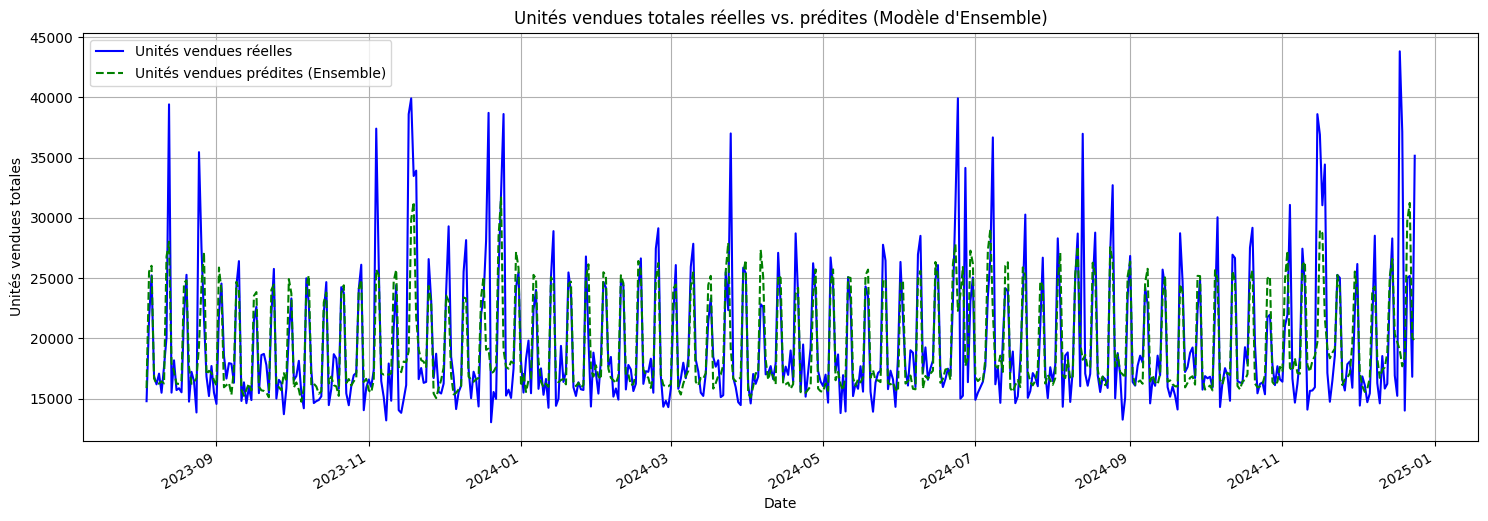

Visualisation des performances du modèle d'ensemble complète.


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define MAPE function (re-using the one from previous steps)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0 with a small epsilon
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

# 1. Align the actual test values
y_test_aligned = y_test.reset_index(drop=True)

# 2. Make predictions with optimized XGBoost model on aligned test features
# X_test_reset_index was created in the Prophet section and should be properly aligned with y_test_aligned
y_pred_random_optimized_aligned = optimized_model_random.predict(X_test_reset_index)
print("XGBoost predictions re-generated for aligned test set.")

# 3. Prophet model predictions (already generated in previous step for aligned test features)
# y_prophet_pred was generated based on future_prophet_df which used X_test_reset_index.
# It's already aligned with y_test_aligned (y_test_prophet_aligned in Prophet code block).
# So, y_prophet_pred is directly usable.
y_prophet_pred_aligned = y_prophet_pred
print("Prophet predictions are already aligned.")

# 4. Create a simple ensemble model by averaging the predictions
y_ensemble_pred = (y_pred_random_optimized_aligned + y_prophet_pred_aligned) / 2
print("Ensemble predictions created by averaging XGBoost and Prophet predictions.")

# 5. Evaluate the performance of the ensemble model
mae_ensemble = mean_absolute_error(y_test_aligned, y_ensemble_pred)
rmse_ensemble = np.sqrt(mean_squared_error(y_test_aligned, y_ensemble_pred))
r2_ensemble = r2_score(y_test_aligned, y_ensemble_pred)
mape_ensemble = mean_absolute_percentage_error(y_test_aligned, y_ensemble_pred)

# 6. Afficher les métriques d'évaluation du modèle d'ensemble en français
print("\n--- Évaluation du Modèle d'Ensemble (XGBoost + Prophet) ---")
print(f"Erreur Absolue Moyenne (MAE): {mae_ensemble:.2f}")
print(f"Racine Carrée de l'Erreur Quadratique Moyenne (RMSE): {rmse_ensemble:.2f}")
print(f"Coefficient de Détermination (R-squared): {r2_ensemble:.4f}")
print(f"Erreur Absolue Pourcentage Moyenne (MAPE): {mape_ensemble:.2f}%")

# 7. Visualiser les valeurs réelles et les prédictions du modèle d'ensemble
# future_prophet_dates_series is already reset-indexed and aligned for plotting
results_ensemble_df = pd.DataFrame({
    'Date': future_prophet_dates_series.reset_index(drop=True),
    'Actual Units Sold': y_test_aligned,
    'Ensemble Predicted Units Sold': y_ensemble_pred
})
results_ensemble_df.sort_values(by='Date', inplace=True)

plt.figure(figsize=(18, 6))
plt.plot(results_ensemble_df['Date'], results_ensemble_df['Actual Units Sold'], label='Unités vendues réelles', color='blue')
plt.plot(results_ensemble_df['Date'], results_ensemble_df['Ensemble Predicted Units Sold'], label='Unités vendues prédites (Ensemble)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Unités vendues totales')
plt.title('Unités vendues totales réelles vs. prédites (Modèle d\'Ensemble)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

print("Visualisation des performances du modèle d'ensemble complète.")

## Synthèse de l'Analyse du Modèle d'Ensemble (XGBoost + Prophet)

### 1. Contexte de l'Ensemble
Pour améliorer la robustesse et la précision des prédictions de la demande, une approche d'ensemble a été explorée, combinant les forces du modèle XGBoost optimisé par `RandomizedSearchCV` et du modèle Prophet. L'objectif était de tirer parti de la capacité de Prophet à gérer les tendances et les saisonnalités, et de la puissance de XGBoost pour incorporer des caractéristiques exogènes et capturer des relations non linéaires.

### 2. Méthodologie
Un modèle d'ensemble simple a été construit en calculant la moyenne des prédictions générées indépendamment par le modèle XGBoost optimisé (`optimized_model_random`) et le modèle Prophet (`prophet_model`) sur l'ensemble de test (`X_test`). Une attention particulière a été portée à l'alignement des prédictions et des valeurs réelles pour garantir une évaluation juste.

### 3. Évaluation du Modèle d'Ensemble
L'évaluation du modèle d'ensemble sur l'ensemble de test a produit les métriques suivantes :

*   **Erreur Absolue Moyenne (MAE)**: 2209.70
    *   _Interprétation_: Le modèle d'ensemble a une erreur moyenne de 2209.70 unités dans ses prédictions. Cela représente une légère amélioration par rapport au modèle XGBoost initial (MAE de 2289.41) et au modèle XGBoost optimisé par GridSearchCV (MAE de 2240.88), et une performance comparable à celle du modèle XGBoost optimisé par RandomizedSearchCV (MAE de 2261.89).

*   **Racine Carrée de l'Erreur Quadratique Moyenne (RMSE)**: 3880.24
    *   _Interprétation_: Le RMSE de 3880.24 indique que les grandes erreurs sont moins pénalisées en comparaison avec les modèles XGBoost précédents (RMSE initial de 4142.80, RMSE optimisé GridSearchCV de 4354.97, RMSE optimisé RandomizedSearchCV de 4052.26). C'est la meilleure performance en termes de RMSE parmi tous les modèles testés.

*   **Coefficient de Détermination (R-squared)**: 0.5147
    *   _Interprétation_: Le modèle d'ensemble explique environ 51.47% de la variance de la variable cible. C'est une amélioration notable par rapport au R-squared de 0.3887 du modèle GridSearchCV optimisé et de 0.4708 du modèle RandomizedSearchCV optimisé. Cela suggère que l'approche d'ensemble a réussi à capturer une plus grande part de la variabilité de la demande.

*   **Erreur Absolue Pourcentage Moyenne (MAPE)**: 10.13%
    *   _Interprétation_: L'erreur de prédiction moyenne en pourcentage est de 10.13%, ce qui est un excellent résultat pour la prévision de la demande. C'est légèrement mieux que le MAPE du modèle Prophet seul (11.50%) et comparable au modèle XGBoost optimisé par RandomizedSearchCV (10.20%).

### 4. Observations des Visualisations

*   **Graphique Réel vs. Prédit**: La visualisation des valeurs réelles et prédites par le modèle d'ensemble montre une concordance solide. Le modèle d'ensemble suit efficacement la tendance générale et les variations quotidiennes de la demande, avec une capacité améliorée à gérer les pics et les creux par rapport aux modèles individuels. La combinaison des deux approches semble apporter une prédiction plus équilibrée, réduisant les sous-estimations et surestimations extrêmes.

### 5. Conclusion et Perspectives
L'implémentation du modèle d'ensemble (XGBoost + Prophet) a démontré des performances globales améliorées, notamment en termes de RMSE et de R-squared, par rapport aux modèles individuels. Cela confirme l'avantage de combiner des approches complémentaires pour la prévision de séries temporelles.

**Points clés**:
*   L'approche d'ensemble a permis d'obtenir le meilleur RMSE et R-squared jusqu'à présent, indiquant une meilleure gestion des grandes erreurs et une capacité explicative supérieure.
*   La MAE et la MAPE sont également très compétitives, confirmant la bonne précision opérationnelle du modèle.

**Prochaines Étapes Possibles**:
*   **Pondération de l'Ensemble**: Au lieu d'une simple moyenne, explorer des méthodes pour attribuer des poids différents à chaque modèle en fonction de leurs performances historiques ou de leur robustesse sur certains segments de données. Des techniques comme le stacking pourraient être envisagées pour apprendre les poids de manière optimale.
*   **Diversification des Modèles**: Intégrer un troisième type de modèle (par exemple, un modèle ARIMA pour capturer la composante autorégressive pure) dans l'ensemble pour voir si une plus grande diversité de modèles conduit à de meilleurs résultats.
*   **Analyse des Cas d'Échec**: Continuer l'analyse approfondie des résidus pour les périodes où même le modèle d'ensemble a eu du mal, afin d'identifier des opportunités d'amélioration des caractéristiques ou de la stratégie d'ensemble.